# Event-Driven Stock Market Analysis


----
#### __Team Details__- QST IS 843 Team 2
#### __Group Members__-
1. Ria Singh
2. Hanying Zhang
3. Nick Kopsiaftis
4. Priyanka Chaudhari


----
### __Team Assignment__

----

### __Table of Contents__

> 1. [Introduction](#part1)
> 2. [Data Description](#part2)
> 3. [Data Loading](#part3)
> 4. [Data Cleaning and Pre-processing](#part4)
> 5. [Exploratory Data Analysis](#part5)
> 6. [Visualizations](#part6)
> 7. [Conclusion and Future Scope](#part7)
> 8. [References and Generative AI Disclosure](#part8)
----

<a id="part1"></a>
## 1.Introduction

----------

### 1.1 Business Problem
his project is designed to conduct the trend analysis, volume-price correlations, and dynamics of stock market trends, along with the multifaceted factors influencing them. Our comprehensive approach aims to dissect and understand the complex interplay between market behaviors, investor sentiment, and external events, offering insights into the underlying mechanisms that drive stock market movements.

### 1.2 Problem Definition
In this project, we will:
- Use moving averages to conduct  trend analysis and performance  comparison of different sectors and companies.
- Analyze trading volume trends alongside price movements to identify correlations between stocks.
- Conduct event impact analysis by observing which popular trends affect stock prices.
- Essentially correlate public sentiment with stock price movements to see if there's a relationship.


### 1.3 Motivation
Given the current volatility and instability of the market, this project aims to delve deep into the factors influencing market trends. By understanding how public sentiment and specific events affect the stock market, we can gain insights into the underlying dynamics driving market fluctuations. This analysis will not only shed light on the direct impact of social and economic events on the stock market but also explore the nuanced ways in which human sentiment influences market behavior.


This dataset consists of two stock Markets data NYSE and NASDAQ along with stock market index S&P500 and Forbes2000. This dataset was hosted on Kaggle.

Data Access link [here](https://www.kaggle.com/datasets/paultimothymooney/stock-market-data/data).


<a id="part2"></a>
## 2.Data Description
----------

### 2.1 Stock Market Dataset

This stock market dataset provides detailed trading information for companies listed in the NYSE, NASDAQ, S&P500 and Forbes 2000. It captures daily trading metrics such as opening price, closing price, highest and lowest prices of the day, volume of shares traded, and the adjusted closing price after accounting for corporate actions. This comprehensive dataset is crucial for analyzing stock performance, market trends, and making informed investment decisions.

Field Name | Type | Description
--- | --- | ---
ID | INTEGER | Unique ID for each company in the Forbes 2000 folder.
Date | TIMESTAMP | Date of when the trade took place.
Low | FLOAT | The minimum price the stock hit throughout the day.
Open | FLOAT | Price of the stock at the start of the trading day.
Volume | INTEGER | The quantity of shares that were traded throughout that day.
High | FLOAT | The maximum (peak) price of the stock throughout the day.
Close | FLOAT | The closing price of the stock.
Adjusted Close | FLOAT | The adjusted closing price, which accounts for all corporate actions such as dividends, stock splits.


### 2.2 Financial Tweet Dataset

This dataset was developed for a 2020 IEEE Big Data conference paper to identify market speculators and influencers. For our project, we utilized tweet and market data, but we've divided the datasets for sharing on Kaggle. This particular set is valuable for analyzing tweets related to Amazon, Apple, Google, Microsoft, and Tesla, based on their stock tickers.

Field Name | Type | Description
--- | --- | ---
tweet_id | STRING | The unique identifier for each tweet.
Date | DATE | The date the tweet was posted.
Body | STRING | The content of the tweet.
Ticker | STRING | The stock symbol the tweet is referencing.

## 3. Importing necessary libraries

In [ ]:
import os
import subprocess
import time
from functools import reduce

from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import to_timestamp, col, coalesce, from_unixtime, lead, lag, lit, month, to_date, year, log
from pyspark.sql.types import BooleanType, DateType, DoubleType, IntegerType, FloatType, LongType, StringType, StructType, StructField
from pyspark.sql.window import Window


In [ ]:
# Create or get SparkSession
spark = SparkSession.builder \
    .appName("Stock Market") \
    .getOrCreate()

if spark.sparkContext._jsc.sc().isStopped():
    print("Creating new SparkSession")
else:
    print("Using existing SparkSession")

Using existing SparkSession


<a id="part7"></a>
## 4.Executive Summary
----------

#### Overview
This analysis commenced with a macroscopic examination of major financial markets, specifically the Nasdaq and NYSE, and the broad market index S&P 500. An initial assessment segmented these markets into various sectors, leading to a focused analysis on the Technology sector within the Nasdaq market due to its significant impact potential.

#### 4.1 Market Behavior and Index Analysis
Utilizing the S&P 500 as a representative benchmark, the study conducted a comprehensive review of annual, quarterly, and historical trends. This provided a foundational understanding of general market behaviors and helped to contextualize fluctuations within the broader economic landscape.

#### 4.2 Feature engineering with stability metrics
A primary objective of this  was to integrate stability metrics for the stocks which would be deemed suitable for novice investors. The stability assessment incorporated several metrics, including Standard Deviation, Average True Range (ATR), daily and average volume, Relative Volume Traded, and Beta. These indicators were instrumental in determining stocks that offer safety amidst market volatility.

#### 4.3 Microscopic Focus on Apple Inc. (AAPL)
The analysis narrowed further to a microscopic examination of Apple Inc. (AAPL), chosen for its prominence within the Technology sector and its significant market activity. This part of the project was characterized as event-driven analysis, centering around the COVID-19 period to evaluate the stock's performance pre-, during, and post-pandemic. Techniques such as moving averages, Relative Strength Index (RSI), and Bollinger Bands were employed to provide detailed insights into the stock’s behavior during these times.

#### 4.4 Sentiment Analysis Through Social Media
An innovative aspect of this study involved collecting Twitter data to perform an extended sentiment analysis. This aimed to quantify the influence of social media sentiment on stock market movements, particularly how public perception as reflected through social media platforms correlates with stock price fluctuations.

#### 4.5 Predictive Modeling
For an extension of this project, a logistic regression model was developed to predict the opening price of stocks. This predictive model is intended to empower users with actionable insights, enabling them to make informed buy or sell decisions based on predicted market movements.

<a id="part3"></a>
## 5.Data Loading
----------
Our dataset was a 10GB cumulative data consisiting of directory for each stock market and index. Inside these directories, each stockdata was stored as an individual file.

*Challenges:* The process of loading data, given its substantial volume, presented a significant challenge. Specifically, aggregating multiple files to construct a unified dataframe for each market and index proved to be a complex task. To mitigate these difficulties, we employed a multi-node cluster to expedite the processing phase. Additionally, we implemented repartitioning strategies to optimize the handling and analysis of this extensive dataset.


### 5.1 Stock Data

In [ ]:
# Define custom date format
custom_date_format = "dd-MM-yyyy"

stockSchema = StructType([
    StructField("Date", StringType(), True),
    StructField("Low", FloatType(), True),
    StructField("Open", FloatType(), True),
    StructField("Volume", LongType(), True),
    StructField("High", FloatType(), True),
    StructField("Close", FloatType(), True),
    StructField("Adjusted_Close", FloatType(), True),
    StructField("Ticker", StringType(), True)
])

In [ ]:
def getStockData (schema, market=None):
        print(f"Processing {market}...")
        datapath = f"gs://bucket_stocks/notebooks/jupyter/stock_market/{market}/csv/"
        gsutil_output = subprocess.check_output(['gsutil', 'ls', f'{datapath}*.csv']).decode('utf-8')
        file_paths = [file_path for file_path in gsutil_output.split('\n') if file_path]
        dfs_list = []
        for file_path in file_paths:
            ticker_name = file_path.split('/')[-1].split('.')[0]
            start = time.time()
            # Read CSV files
            dfs = spark.read.csv(
                path=file_path,
                header=True,
                schema=schema,
                quote='"',
                nullValue="NA",
                escape='"'
            ).select("Date", "Low", "Open", "Volume", "High", "Close", "Adjusted_Close").withColumn("Ticker", lit(ticker_name))
            # Convert Date column to DateType
            # dfs = dfs.withColumn("Date", to_date("Date", custom_date_format))

            dfs_list.append(dfs)
        # Concatenate all DataFrames for the current market
        concatenated_df = reduce(lambda df1, df2: df1.unionAll(df2), dfs_list)
        concatenated_df = concatenated_df.withColumnRenamed("Adjusted_Close", f"Adjusted_Close_{market}")

        # Increase the number of partitions for better parallelism
        concatenated_df = concatenated_df.repartition(14)  # Adjust the number of partitions

        # Cache the concatenated DataFrame in memory for reuse
        concatenated_df.cache()

        end = time.time()

        print(f"{market} df creation time: {end - start}")
        print("--------------------------------------------------------")
        return concatenated_df

In [ ]:
df_nasdaq = getStockData(stockSchema,"nasdaq")
df_nasdaq.show(10)

Processing nasdaq...
nasdaq df creation time: 370.10539507865906
--------------------------------------------------------


24/04/29 15:56:26 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB


+----------+-----+-----+--------+-----+-----+---------------------+------+
|      Date|  Low| Open|  Volume| High|Close|Adjusted_Close_nasdaq|Ticker|
+----------+-----+-----+--------+-----+-----+---------------------+------+
|18-01-2011|10.07|10.71| 6080000|10.71|10.12|             9.540542|   AAL|
|31-07-2019|30.27|30.68| 6269400|31.14|30.51|            30.193249|   AAL|
|24-08-2022|13.77|13.84|17825100|14.05|13.99|                13.99|   AAL|
|24-05-2021|22.35|22.85|26159300|23.05|22.99|                22.99|   AAL|
|20-05-2013|18.39|19.05| 6055000|19.39|18.59|            17.525564|   AAL|
|02-02-2007|56.66| 57.0| 2171700|58.76|57.98|            54.660156|   AAL|
|30-10-2019|29.93|30.77|10356100|30.94|30.29|             30.08097|   AAL|
|29-10-2020|10.89|10.96|44070600|11.29|11.16|                11.16|   AAL|
|17-07-2009| 2.02|  2.1| 3432900|  2.1| 2.04|            1.9231925|   AAL|
|06-08-2012| 10.8|10.94| 5529000|11.12|10.81|            10.191034|   AAL|
+----------+-----+-----+-

In [ ]:
df_nyse = getStockData(stockSchema, "nyse")
df_nyse.show(10)

Processing nyse...
nyse df creation time: 225.81043457984924
--------------------------------------------------------


24/04/29 17:39:03 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


+----------+-----+----+-------+-----+-----+-------------------+------+
|      Date|  Low|Open| Volume| High|Close|Adjusted_Close_nyse|Ticker|
+----------+-----+----+-------+-----+-----+-------------------+------+
|13-01-2022| 9.76|9.78|  33500| 9.78| 9.76|               9.76|   AAC|
|16-08-2021| 9.69|9.72| 170700| 9.73| 9.72|               9.72|   AAC|
|10-06-2022| 9.82|9.83| 203400|9.835| 9.83|               9.83|   AAC|
|07-09-2022| 9.91|9.91| 127600| 9.92| 9.92|               9.92|   AAC|
|30-06-2021| 9.75|9.76|  19800| 9.79| 9.75|               9.75|   AAC|
|14-04-2022| 9.82|9.87|  14600| 9.87| 9.82|               9.82|   AAC|
|24-01-2022|  9.7|9.72| 143200| 9.74|  9.7|                9.7|   AAC|
|03-05-2021|  9.8|9.87|2208200| 9.87| 9.81|               9.81|   AAC|
|21-10-2022| 9.94|9.94| 103100| 9.96| 9.96|               9.96|   AAC|
|04-01-2022|9.745|9.77|1523400| 9.78| 9.78|               9.78|   AAC|
+----------+-----+----+-------+-----+-----+-------------------+------+
only s

In [ ]:
df_sp500 = getStockData(stockSchema, "sp500")
df_sp500.show(10)

Processing sp500...
sp500 df creation time: 19.914846420288086
--------------------------------------------------------


24/04/29 17:47:31 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


+----------+---------+---------+-------+---------+---------+--------------------+------+
|      Date|      Low|     Open| Volume|     High|    Close|Adjusted_Close_sp500|Ticker|
+----------+---------+---------+-------+---------+---------+--------------------+------+
|10-04-2006|26.216022|27.010014|3005281|27.181688|26.409157|           22.596521|     A|
|15-05-2001|26.466381|27.074392|2367233| 27.81116|26.788269|             22.9209|     A|
|04-12-2007|26.773964|26.895565|4236639|27.281832|26.809729|           24.345997|     A|
|09-12-2010|27.017166|27.074392|4770395|27.224607|27.217455|           24.716257|     A|
|19-07-2012|27.153076|27.296137|2968513|27.610872| 27.51073|           25.105457|     A|
|30-12-2020|   117.33|   117.86|1127000|    118.9|   117.39|          115.978035|     A|
|01-04-2008| 21.39485| 21.39485|3152490|22.160229|22.095852|           20.065315|     A|
|29-01-2002| 20.74392|21.030043|2198075|21.530758|20.922747|           17.902178|     A|
|06-08-2009|16.552217

### 5.2 Making Copy of Data

In [ ]:
df_nasdaq_raw=df_nasdaq
df_nyse_raw=df_nyse
df_sp500_raw=df_sp500

<a id="part4"></a>
## 6 Data Cleaning, Preprocessing and Exploratory Data Analysis
----------

#### a.  Time Column Management:
&nbsp;&nbsp;&nbsp;&nbsp;The opening date in the time column was utilized to derive the month and year, enabling the execution of both monthly and annual analyses. Additionally, the dates were formatted correctly to the appropriate date type.


#### b. Managing Missing or Null Entries:
&nbsp;&nbsp;&nbsp;&nbsp;For every dataset, missing or null entries were addressed by employing an averaging technique that combines both forward and backward filling methods.


#### c. Incorporation of Sector and Country Information:
&nbsp;&nbsp;&nbsp;&nbsp;Sector and country details for each stock ticker were augmented by sourcing data from the Yahoo Finance API.


#### d. Enhancing Column Name Clarity:
&nbsp;&nbsp;&nbsp;&nbsp;Column names were made more readable through the use of formatted strings (f-strings), adhering to a uniform naming convention across markets (e.g., `col_{market}`). This approach was chosen to enhance efficiency and minimize the need for brute-force naming strategies.


#### e. Elimination of Duplicate Records:
&nbsp;&nbsp;&nbsp;&nbsp;Duplicate entries within the dataset were identified and removed to ensure data integrity and accuracy.



### 6.1 Handling Null Values

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as sum_, when
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

def processNull(df, market=None):
    print(f"Calculating null values in {market}")
    nullCount(df)

    print("check null values for volume column...")
    columns_of_interest = [ 'Volume']
    specific_null_filter = " OR ".join([f"{c} IS NULL" for c in columns_of_interest])
    specific_rows_with_nulls = df.filter(specific_null_filter).orderBy(["Ticker","Date"])
    specific_rows_with_nulls.show(10)

    print("Drop null value rows...")
    df = df.na.drop(subset=["Volume"])

    print("Final check for null values...")
    nullCount(df)
    print("Processing complete...")
    return df

# get count of null values in all cols of df
def nullCount(df):
    null_counts_column = {c: sum_(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df.columns}
    nulls_df = df.select([null_counts_column[c] for c in df.columns])
    nulls_df.show()

In [ ]:
df_nasdaq=processNull(df_nasdaq, "Nasdaq")
df_nyse=processNull(df_nyse, "NYSE")
df_sp500=processNull(df_sp500, "S&P 500")

Calculating null values in Nasdaq


+----+---+----+------+----+-----+---------------------+------+-----+----+
|Date|Low|Open|Volume|High|Close|Adjusted_Close_nasdaq|Ticker|Month|Year|
+----+---+----+------+----+-----+---------------------+------+-----+----+
|   1|  0|   0|     0|   0|    0|                    0|     0|    1|   1|
+----+---+----+------+----+-----+---------------------+------+-----+----+

check null values for volume column...


+----+---+----+------+----+-----+---------------------+------+-----+----+
|Date|Low|Open|Volume|High|Close|Adjusted_Close_nasdaq|Ticker|Month|Year|
+----+---+----+------+----+-----+---------------------+------+-----+----+
+----+---+----+------+----+-----+---------------------+------+-----+----+

Drop null value rows...
Final check for null values...


+----+---+----+------+----+-----+---------------------+------+-----+----+
|Date|Low|Open|Volume|High|Close|Adjusted_Close_nasdaq|Ticker|Month|Year|
+----+---+----+------+----+-----+---------------------+------+-----+----+
|   1|  0|   0|     0|   0|    0|                    0|     0|    1|   1|
+----+---+----+------+----+-----+---------------------+------+-----+----+

Processing complete...
Calculating null values in NYSE


+----+-----+-----+------+-----+-----+-------------------+------+
|Date|  Low| Open|Volume| High|Close|Adjusted_Close_nyse|Ticker|
+----+-----+-----+------+-----+-----+-------------------+------+
|   0|94982|94982|377107|94982|94982|              94982|     0|
+----+-----+-----+------+-----+-----+-------------------+------+

check null values for volume column...


+----------+----+----+------+----+-----+-------------------+------+
|      Date| Low|Open|Volume|High|Close|Adjusted_Close_nyse|Ticker|
+----------+----+----+------+----+-----+-------------------+------+
|01-02-2021|null|null|  null|null| null|               null|   ACG|
|01-02-2022|null|null|  null|null| null|               null|   ACG|
|01-03-2021|null|null|  null|null| null|               null|   ACG|
|01-03-2022|null|null|  null|null| null|               null|   ACG|
|01-04-2020|null|null|  null|null| null|               null|   ACG|
|01-04-2021|null|null|  null|null| null|               null|   ACG|
|01-04-2022|null|null|  null|null| null|               null|   ACG|
|01-05-2020|null|null|  null|null| null|               null|   ACG|
|01-06-2020|null|null|  null|null| null|               null|   ACG|
|01-06-2021|null|null|  null|null| null|               null|   ACG|
+----------+----+----+------+----+-----+-------------------+------+
only showing top 10 rows

Drop null value rows..

+----+---+----+------+----+-----+-------------------+------+
|Date|Low|Open|Volume|High|Close|Adjusted_Close_nyse|Ticker|
+----+---+----+------+----+-----+-------------------+------+
|   0|  0|   0|     0|   0|    0|                  0|     0|
+----+---+----+------+----+-----+-------------------+------+

Processing complete...
Calculating null values in S&P 500


+----+----+----+------+----+-----+--------------------+------+
|Date| Low|Open|Volume|High|Close|Adjusted_Close_sp500|Ticker|
+----+----+----+------+----+-----+--------------------+------+
|   0|7577|7577| 66696|7577| 7577|                7577|     0|
+----+----+----+------+----+-----+--------------------+------+

check null values for volume column...
+----------+-----+-----+------+-----+-----+--------------------+------+
|      Date|  Low| Open|Volume| High|Close|Adjusted_Close_sp500|Ticker|
+----------+-----+-----+------+-----+-----+--------------------+------+
|01-02-2019| 0.06|0.061|  null|0.063|0.062|               0.062|   BHI|
|01-02-2021| null| null|  null| null| null|                null|   BHI|
|01-02-2022| null| null|  null| null| null|                null|   BHI|
|01-03-2019|0.064|0.065|  null|0.066|0.065|               0.065|   BHI|
|01-03-2021| null| null|  null| null| null|                null|   BHI|
|01-03-2022| null| null|  null| null| null|                null|   BH

+----+---+----+------+----+-----+--------------------+------+
|Date|Low|Open|Volume|High|Close|Adjusted_Close_sp500|Ticker|
+----+---+----+------+----+-----+--------------------+------+
|   0|  0|   0|     0|   0|    0|                   0|     0|
+----+---+----+------+----+-----+--------------------+------+

Processing complete...


In [ ]:
# check high null values
columns_of_interest = [ 'High']
specific_null_filter = " OR ".join([f"{c} IS NULL" for c in columns_of_interest])
specific_rows_with_nulls = df_nasdaq.filter(specific_null_filter).orderBy(["Ticker","Date"])
df_nasdaq = df_nasdaq.na.drop(subset=["High"])

In [ ]:
from pyspark.sql.window import Window
from pyspark.sql import functions as F

def fill_nulls_with_avg_forward_backward(df, column_name, market=None):
    if column_name == 'Adjusted_Close':
        column_name = f'Adjusted_Close_{market}'

    print(f"Filling null values for {market}")
    # Define the window specification for ordering
    windowSpec = Window.orderBy("Date")

    print("Calculating forward and backward fill...")
    # Calculate the forward fill (next non-null value) and backward fill (previous non-null value)
    forward_fill = lead(column_name, 1).over(windowSpec)
    backward_fill = lag(column_name, 1).over(windowSpec)

    print("Calculating avg fill...")
    # Average of forward and backward fill
    average_fill = (coalesce(forward_fill, backward_fill) + coalesce(backward_fill, forward_fill)) / 2

    print("Fill null values with avg fill...")
    # Fill nulls with the calculated average
    df_filled = df.withColumn(column_name, coalesce(col(column_name), average_fill))
    print(f"Completed processing for: {market}")
    df.show(5)
    print("------------------------------------")
    return df_filled



In [ ]:
# columns = ['Low', 'Open', 'Volume', 'High', 'Close' , 'Adjusted_Close']
# for col in columns:
#     df_nasdaq = fill_nulls_with_avg_forward_backward(df_nasdaq, col, "nasdaq")
#     df_nyse = fill_nulls_with_avg_forward_backward(df_nyse, "Date", "nyse")

### 6.2 Date Manipulation

In [ ]:
# date manipulation
from pyspark.sql.functions import to_date, col, month, year

# Assuming 'dataframes' is your dictionary of PySpark DataFrames
def add_date( df, market=None):
    print(f"Adding month & year in {market}")

    # Convert Date column to proper date type
    df = df.withColumn("Date", to_date(col("Date"), "dd-MM-yyyy"))

    print(f"Adding month...")
    df = df.withColumn("Month", month("Date"))
    print(f"Adding year...")
    df = df.withColumn("Year", year("Date"))
    print(f"Completed processing for: {market}")
    df.show(5)
    print("------------------------------------")
    return df

In [ ]:
df_nasdaq = add_date(df_nasdaq,"nasdaq")
df_nyse = add_date(df_nyse,"nyse")
df_sp500 = add_date(df_sp500,"S&P500")

Adding month & year in nyse
Adding month...
Adding year...
Completed processing for: nyse


+----------+------+------+-------+------+------+-------------------+------+-----+----+
|      Date|   Low|  Open| Volume|  High| Close|Adjusted_Close_nyse|Ticker|Month|Year|
+----------+------+------+-------+------+------+-------------------+------+-----+----+
|2022-11-11| 9.985|  9.99|  27900|  10.0| 9.995|              9.995|   AAC|   11|2022|
|2016-11-08| 136.1|137.45| 921000| 139.0|137.67|           130.4678|   AAP|   11|2016|
|2013-12-18|106.88|108.85|1104500|109.56|109.27|          103.09093|   AAP|   12|2013|
|2017-07-06| 38.79|  39.2| 175000| 39.43| 38.89|           32.74509|   AAT|    7|2017|
|2012-06-22| 22.85| 23.47|1331300| 23.47| 22.91|          16.943174|   AAT|    6|2012|
+----------+------+------+-------+------+------+-------------------+------+-----+----+
only showing top 5 rows

------------------------------------
Adding month & year in S&P500
Adding month...
Adding year...
Completed processing for: S&P500


+----------+---------+---------+---------+---------+---------+--------------------+------+-----+----+
|      Date|      Low|     Open|   Volume|     High|    Close|Adjusted_Close_sp500|Ticker|Month|Year|
+----------+---------+---------+---------+---------+---------+--------------------+------+-----+----+
|2018-01-26|    73.59|     74.3|  2386900|    74.83|    74.82|            72.15505|     A|    1|2018|
|2004-06-23|18.741058|18.741058|  3722175|19.384834|19.341917|           16.549566|     A|    6|2004|
|2011-01-20|     9.67|     9.98|  7261600|     10.3|    10.25|            9.663102|   AAL|    1|2011|
|2022-10-21|    169.5|   170.59|   826300|   172.78|   171.34|              171.34|   AAP|   10|2022|
|2012-10-01|23.446428|    23.97|543594800|24.169643|23.549643|           20.160322|  AAPL|   10|2012|
+----------+---------+---------+---------+---------+---------+--------------------+------+-----+----+
only showing top 5 rows

------------------------------------


### 6.3 Removing Duplicates

In [ ]:
# count number of duplicates:
import pyspark.sql.functions as F

print("Removing duplicates in nasdaq...")
df_nasdaq.groupBy(df_nasdaq.columns)\
    .count()\
    .where(F.col('count') > 1)\
    .select(F.sum('count'))\
    .show()

print("Removing duplicates in nyse...")
df_nyse.groupBy(df_nyse.columns)\
    .count()\
    .where(F.col('count') > 1)\
    .select(F.sum('count'))\
    .show()

print("Removing duplicates in S&P 500...")
df_sp500.groupBy(df_sp500.columns)\
    .count()\
    .where(F.col('count') > 1)\
    .select(F.sum('count'))\
    .show()

Removing duplicates in nasdaq...


+----------+
|sum(count)|
+----------+
|         2|
+----------+

Removing duplicates in nyse...


+----------+
|sum(count)|
+----------+
|      null|
+----------+

Removing duplicates in S&P 500...


+----------+
|sum(count)|
+----------+
|      null|
+----------+



In [ ]:
df_nasdaq = df_nasdaq.dropDuplicates()
df_nyse = df_nyse.dropDuplicates()
df_sp500 = df_sp500.dropDuplicates()
print("Duplicate Removal for all complete")

Duplicate Removal for all complete


### 6.4 Adding sectors to the stocks

In [ ]:
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql import functions as F
from functools import reduce

# Initialize Spark session
spark = SparkSession.builder.appName("Stock Ticker Analysis").getOrCreate()

def union_all(dfs):
    return reduce(DataFrame.unionByName, dfs) if dfs else None

def calculate_unique_tickers(*dataframes):
    # Initialize an empty list to collect distinct ticker DataFrames
    all_tickers_df_list = []

    # Collect distinct tickers from each DataFrame passed
    for df in dataframes:
        distinct_tickers = df.select("Ticker").distinct()
        all_tickers_df_list.append(distinct_tickers)

    # Create a union of all ticker DataFrames and remove duplicates
    if all_tickers_df_list:
        all_tickers_union_df = union_all(all_tickers_df_list).distinct()
    else:
        return []  # Return an empty list if no dataframes are provided

    # Collect unique tickers into a list
    all_unique_tickers = [row['Ticker'] for row in all_tickers_union_df.collect()]

    print(f"Total unique Ticker count across all DataFrames: {len(all_unique_tickers)}")
    return all_unique_tickers

def get_ticker_details(ticker):
    # print(f"Getting {ticker} data...")
    stock = yf.Ticker(ticker)
    info = stock.info
    # print(info)
    sector = info.get('sector', 'Unknown')
    country = info.get('country', 'Unknown')
    return {'sector': sector, 'country': country}

    return {"details": "Details for " + ticker}

# Calculating unique tickers
unique_tickers = calculate_unique_tickers(df_nasdaq, df_nyse, df_sp500)

# Creating ticker details map
print("Start...")
tickers_map = {}
for ticker in unique_tickers:
    tickers_map[ticker] = get_ticker_details(ticker)

In [ ]:
%pip install yfinance

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType

schema = StructType([
    StructField("Ticker", StringType(), True),
    StructField("Sector", StringType(), True),
    StructField("Country", StringType(), True)
])

ticker_details = [(ticker, details['sector'], details['country']) for ticker, details in tickers_map.items()]

ticker_details_df = spark.createDataFrame(ticker_details, schema)


df_nasdaq = df_nasdaq.join(ticker_details_df, on="Ticker", how="left")
df_nyse = df_nyse.join(ticker_details_df, on="Ticker", how="left")
df_sp500 = df_sp500.join(ticker_details_df, on="Ticker", how="left")



In [ ]:
from pyspark.sql.functions import col

null_counts = {}

null_count = df_nasdaq.filter(col("sector").isNull()).count()
null_counts[df_nasdaq] = null_count

null_count = df_nyse.filter(col("sector").isNull()).count()
null_counts[df_nyse] = null_count

null_count = df_sp500.filter(col("sector").isNull()).count()
null_counts[df_sp500] = null_count


In [ ]:
null_counts

{DataFrame[Ticker: string, Date: date, Low: float, Open: float, Volume: bigint, High: float, Close: float, Adjusted_Close_nasdaq: float, Month: int, Year: int, Sector: string, Country: string]: 0,
 DataFrame[Ticker: string, Date: date, Low: float, Open: float, Volume: bigint, High: float, Close: float, Adjusted_Close_nyse: float, Month: int, Year: int, Sector: string, Country: string]: 0,
 DataFrame[Ticker: string, Date: date, Low: float, Open: float, Volume: bigint, High: float, Close: float, Adjusted_Close_sp500: float, Month: int, Year: int, Sector: string, Country: string]: 0}

<a id="part4"></a>
###6.5 Feature Generation
----------

1. **Average Daily Returns:** This metric is computed for stocks, in each market by comparing the closing price of a stock on a day to its previous days closing price. By averaging these returns it offers valuable insights into a stocks typical performance while accounting for daily fluctuations. We can use this to analyze the trend and profitability of stocks.

2. **Market Volatility:** It is measured as the deviation of returns reflects the variability in returns for a specific stock and indicates the level of risk associated with its price movements. High volatility suggests that a stocks price can fluctuate significantly within a timeframe signaling risk but also potentially higher rewards.

3. **Average Trading Volume:** This parameter denotes the number of shares exchanged over a defined period serving as an indicator of liquidity. A high trading volume signifies interest, in trading activities related to a particular stock whether for buying or selling purposes.
Conversely, low trading volume could indicate interest or possibly reduced liquidity posing challenges when trying to make significant trades without impacting the stocks value.

###6.6 Making copy of preprocessed data

In [ ]:
df_nasdaq_copy=df_nasdaq
df_nyse_copy=df_nyse
df_sp500_copy=df_sp500

## 7 Sector Analysis

### 7.1 How does the average daily return vary across different sectors within each market?

Processing: nasdaq
Completed processing for: nasdaq
--------------
Processing: nyse
Completed processing for: nyse
--------------
Processing: sp500
Completed processing for: sp500
--------------
Processing: nasdaq


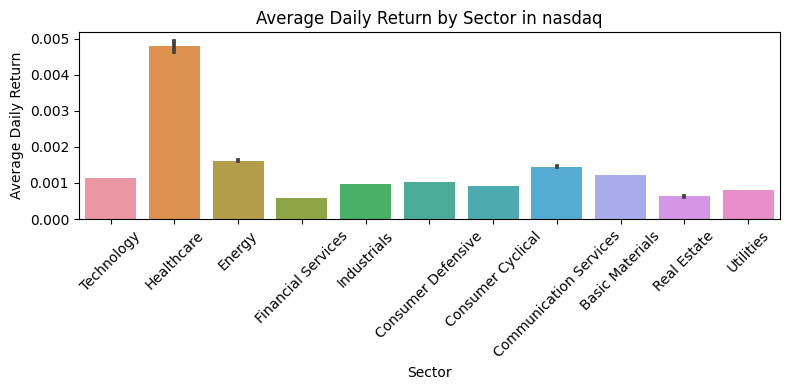

--------------
Processing: nyse


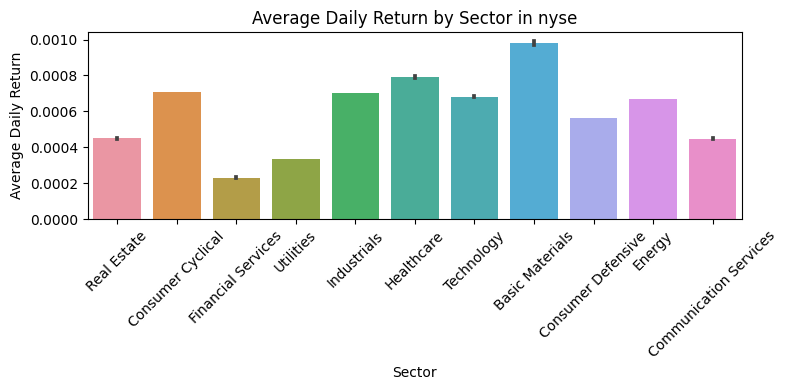

--------------
Processing: sp500


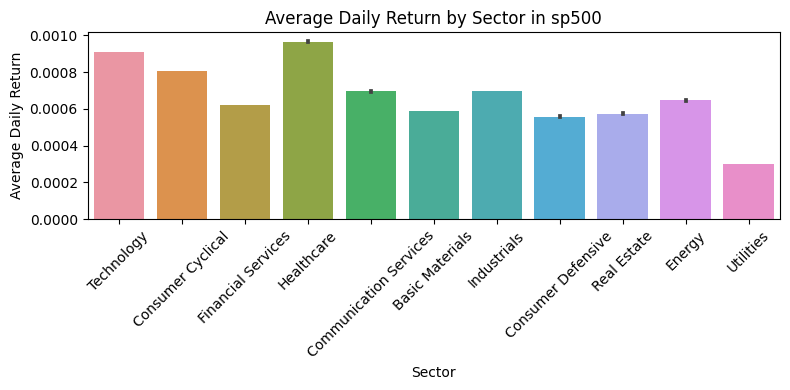

--------------


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, stddev, lag, to_date, first
from pyspark.sql.window import Window


dataframes = {'nasdaq':df_nasdaq,'nyse':df_nyse,'sp500':df_sp500}

def historical_baseline(df, market):
    df = df.withColumn("Date", to_date(col("Date"), "dd-MM-yyyy"))

    # Window Spec
    windowSpec = Window.partitionBy("Ticker").orderBy("Date")

    # Calculate daily returns
    df = df.withColumn("prev_Close", lag("Close").over(windowSpec))
    df = df.withColumn("daily_return", (col("Close") - col("prev_Close")) / col("prev_Close"))

    # Calculate historical metrics
    historical_metrics = df.groupBy("Ticker").agg(
        avg("daily_return").alias(f"{market}_avg_daily_return"),
        stddev("daily_return").alias(f"{market}_volatility"),
        avg("Volume").alias(f"{market}_avg_volume")
    )

    df_joined = df.join(historical_metrics, ["Ticker"], "left").drop("prev_Close", "daily_return")

    return df_joined

for market_name, df in dataframes.items():
    print(f"Processing: {market_name}")

    df_updated = historical_baseline(df, market_name)

    dataframes[market_name] = df_updated

    print(f"Completed processing for: {market_name}")
    print("--------------")

def plot_avg_daily_return(df_pandas, market_name, avg_daily_return_col):
    plt.figure(figsize=(8, 4))
    sns.barplot(data=df_pandas, x='Sector', y=avg_daily_return_col)
    plt.xticks(rotation=45)
    plt.title(f'Average Daily Return by Sector in {market_name}')
    plt.ylabel('Average Daily Return')
    plt.xlabel('Sector')
    plt.tight_layout()
    plt.show()

for market_name, df in dataframes.items():
    print(f"Processing: {market_name}")

    avg_daily_return_col = f'{market_name}_avg_daily_return'

    if avg_daily_return_col in df.columns and 'Sector' in df.columns:
        df_pandas = df.toPandas()

        df_filtered = df_pandas[df_pandas['Sector'] != 'Unknown']

        plot_avg_daily_return(df_filtered, market_name, avg_daily_return_col)
    else:
        print(f"Skipping {market_name} due to missing columns.")
    print("--------------")


Each chart shows a different sector as the top performer, indicating that sector performance can vary widely across different indices.

In the S&P 500, the Healthcare sector stands out with a significantly higher average daily return compared to other sectors. For the NYSE, the Technology sector shows an exceptionally higher average daily return than other sectors. In the NASDAQ, the Technology sector leads with the highest average daily return by a substantial margin.

The scale of average daily returns varies across the indices, with NASDAQ showing a much higher range of returns, followed by S&P 500 and NYSE show more modest ranges in comparison.

### 7.2 What is the general trend of the average adjusted close price of the S&P 500 index in 2022?

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import matplotlib.pyplot as plt

df_sp500 = df_sp500.withColumn("Date", F.to_date(df_sp500["Date"], "dd-MM-yyyy"))
market='sp500'
df_filtered = df_sp500.filter((df_sp500["Date"] >= F.lit("2000-01-01")) &
                                      (df_sp500["Date"] <= F.lit("2022-12-31")))

windowSpec = Window.partitionBy().orderBy("Date")

for market in ["sp500"]:
    df_filtered = df_filtered.withColumn(f"Log_Return_{market}",
                                         F.log(F.col(f"Adjusted_Close_{market}") /
                                               F.lag(F.col(f"Adjusted_Close_{market}")).over(windowSpec)))

normalized_log_returns = {}
for market in ["sp500"]:
    first_log_return = df_filtered.filter(df_filtered["Date"] >= F.lit("2000-01-01")).select(f"Log_Return_{market}").dropna().first()[0]
    normalized_log_returns[f"Normalized_Log_Return_{market}"] = df_filtered[f"Log_Return_{market}"] - first_log_return

for market, column in normalized_log_returns.items():
    df_filtered = df_filtered.withColumn(market, column)

plot_data = df_filtered.groupBy("Date").agg(
    F.avg("Normalized_Log_Return_sp500").alias("Avg_Log_Return_SP500")
    # F.avg("Normalized_Log_Return_nyse").alias("Avg_Log_Return_NYSE"),
    # F.avg("Normalized_Log_Return_nasdaq").alias("Avg_Log_Return_NASDAQ")
    # F.avg("Normalized_Log_Return_forbes2000").alias("Avg_Log_Return_Forbes2000")
).orderBy("Date").toPandas()

plt.figure(figsize=(14, 7))
plt.plot(plot_data["Date"], plot_data["Avg_Log_Return_SP500"], label="S&P 500")
# plt.plot(plot_data["Date"], plot_data["Avg_Log_Return_NYSE"], label="NYSE")
# plt.plot(plot_data["Date"], plot_data["Avg_Log_Return_NASDAQ"], label="NASDAQ")
# plt.plot(plot_data["Date"], plot_data["Avg_Log_Return_Forbes2000"], label="Forbes 2000")
plt.xlabel("Year")
plt.ylabel("Normalized Average Daily Log Return")
plt.title("Normalized Average Daily Log Return (2000-2022)")
plt.legend()
plt.grid(True)
plt.show()

df_sp500=df_sp500_copy


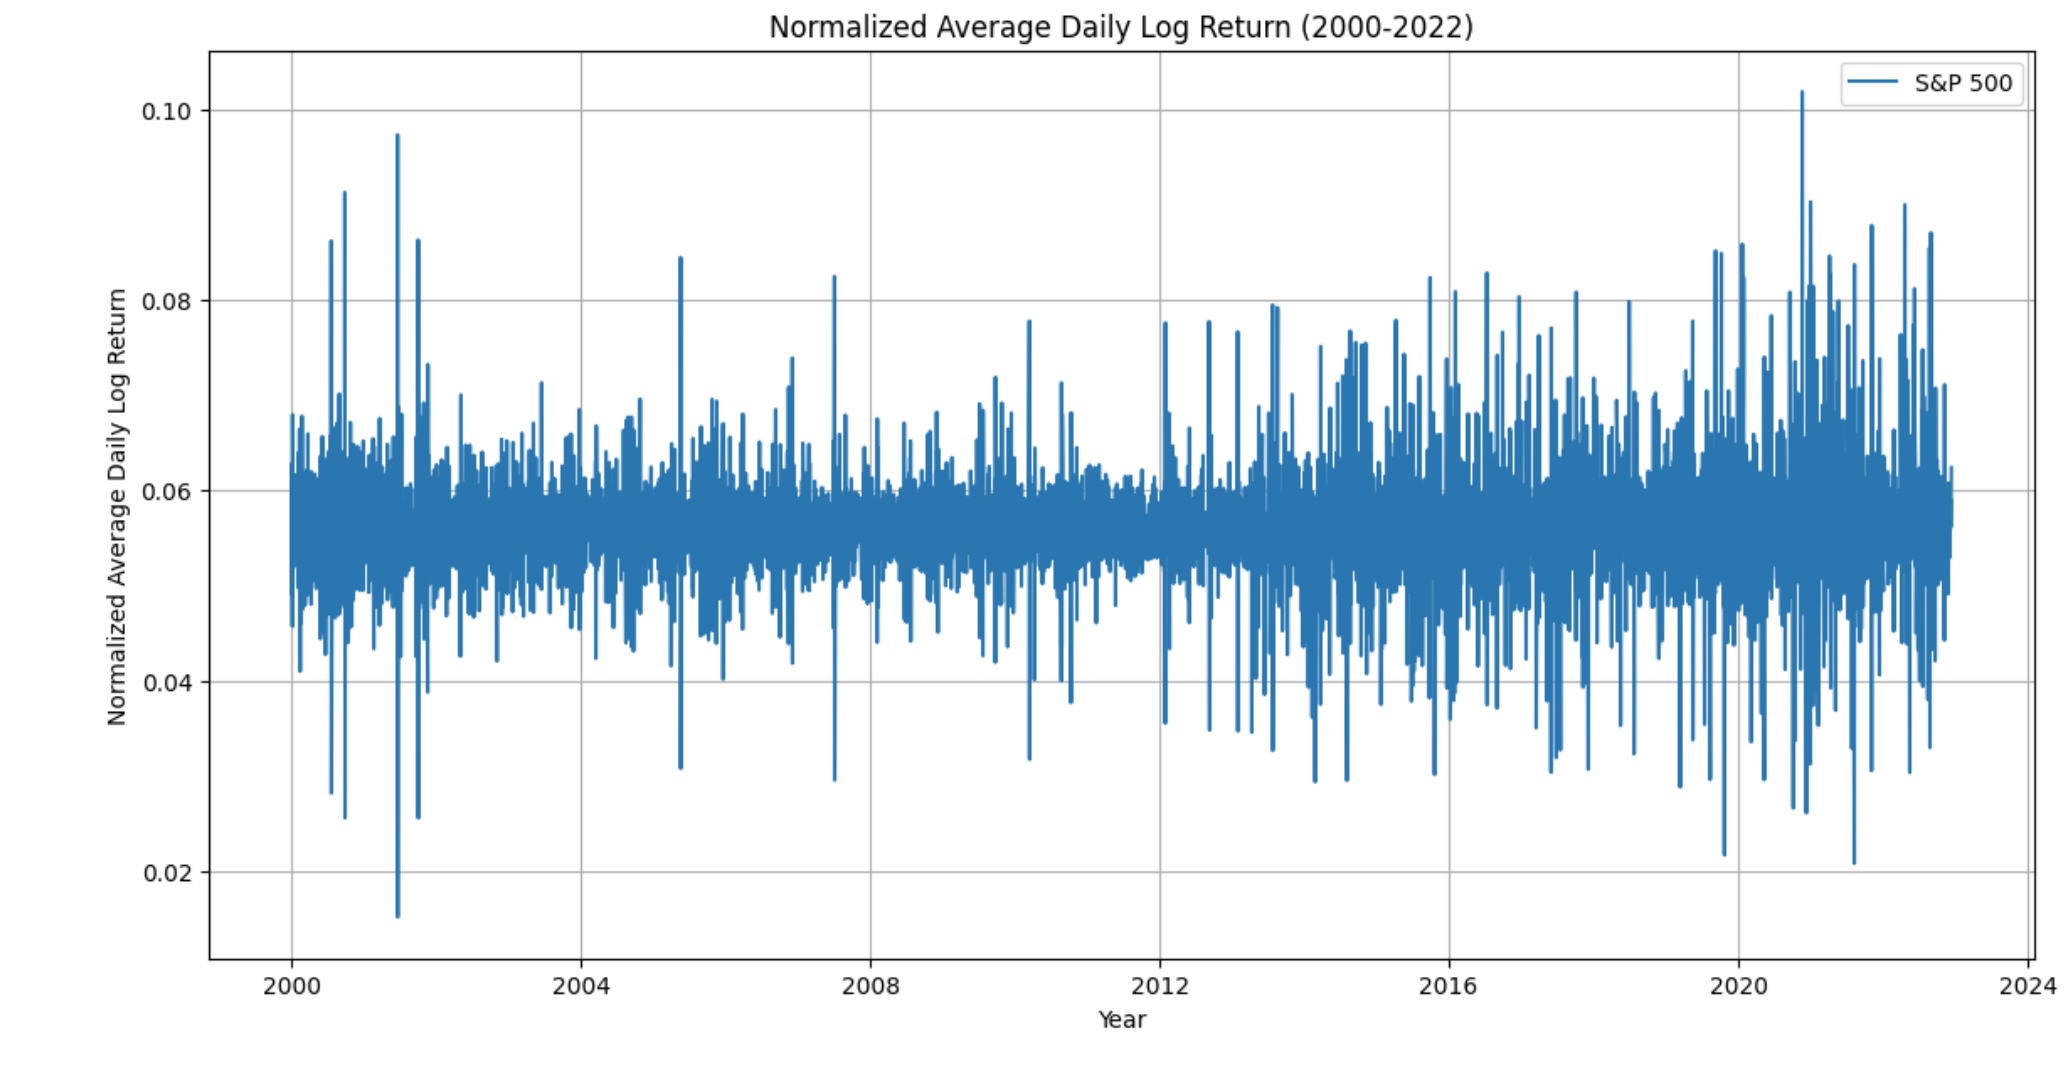

In the above scenario, the Normalized Average Daily Log Return for different stock indices from 2000 to 2022 is depicted in the graph, here are some points we analysed:
1. S&P 500: The blue line represents the S&P 500 index. It shows fluctuations in returns over the years. Notably, the index experienced significant volatility during the dot-com bubble (early 2000s) and the global financial crisis (2008-2009).

2. NYSE: The orange line represents the New York Stock Exchange (NYSE). Similar to the S&P 500, it exhibits volatility during major market events. The NYSE’s performance closely tracks the broader market.

3. NASDAQ: The green line represents the NASDAQ index. NASDAQ is known for its technology-heavy composition. It shows strong growth during the dot-com era and continued resilience in recent years.

Overall, the stock market indices have experienced varying levels of volatility and growth over the past two decades. Investors should consider diversification and long-term strategies based on their risk tolerance and investment goals.


### Feature Addition

In [ ]:
df_nasdaq.cache()
df_nyse.cache()
df_sp500.cache()

24/04/29 07:39:34 WARN CacheManager: Asked to cache already cached data.
24/04/29 07:39:34 WARN CacheManager: Asked to cache already cached data.


DataFrame[Date: date, Low: float, Open: float, Volume: bigint, High: float, Close: float, Adjusted_Close_sp500: float, Ticker: string, Month: int, Year: int]

### 8 Gap Analysis

In [ ]:
pip install statsmodels

In [ ]:
pip install mplfinance

####8.1 How did AAPL stock perform during COVID?

Number of entries for AAPL in 2022: 1287


/opt/conda/miniconda3/lib/python3.10/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


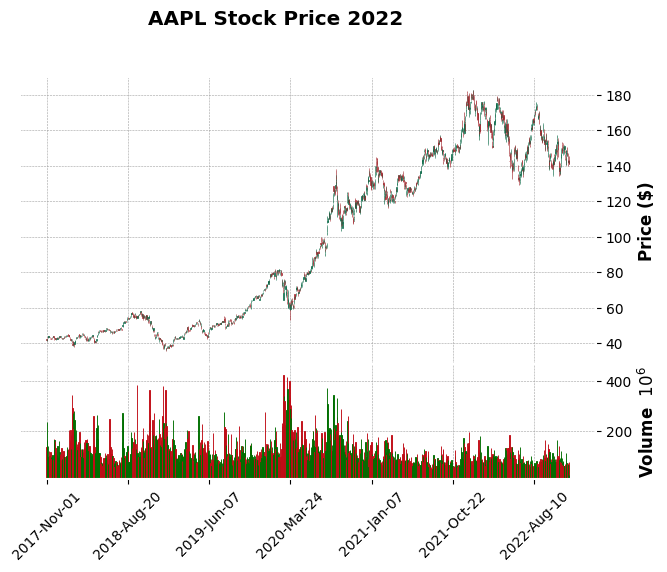

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import mplfinance as mpf
import pandas as pd


df_nasdaq_GA=df_nasdaq
# Convert the Date column to the appropriate date type
df_nasdaq_GA = df_nasdaq_GA.withColumn("Date", F.to_date(df_nasdaq_GA["Date"], "dd-MM-yyyy"))

# Filter for AAPL stock data for the year 2022
df_aapl_2022 = df_nasdaq_GA.filter(
    (df_nasdaq_GA['Ticker'] == 'AAPL') &
    (df_nasdaq_GA['Date'] >= F.lit('2017-11-01')) &
    (df_nasdaq_GA['Date'] <= F.lit('2023-12-31'))
).select('Date', 'Open', 'High', 'Low', 'Close', 'Volume').orderBy('Date')

# Debugging: Check the number of entries after filtering
print("Number of entries for AAPL in 2022:", df_aapl_2022.count())

# Convert to Pandas DataFrame for visualization
pandas_df = df_aapl_2022.toPandas()

# Ensure the 'Date' column is a DatetimeIndex
pandas_df.set_index(pd.to_datetime(pandas_df['Date']), inplace=True)
pandas_df.drop(columns=['Date'], inplace=True)  # Remove the 'Date' column as it's now the index

# Check if DataFrame is empty
if pandas_df.empty:
    print("DataFrame is empty. Check data extraction and filtering steps.")
else:
    # Create a candlestick chart
    mpf.plot(pandas_df, type='candle', style='charles',
             title="AAPL Stock Price 2022",
             ylabel='Price ($)',
             volume=True,
             show_nontrading=False)



Candle Stick Chart
The presence of long wicks can indicate volatility within the trading day, showing that prices moved significantly away from the open and close but reverted before the end of the trading period. Several long wicks on both the upper and lower ends of the candlesticks throughout the year suggest that AAPL's stock price experienced quite a bit of intraday volatility.
The chart shows both bullish periods during March, June and July(green candles) where the stock closed higher than it opened, and bearish periods during April, May and September(red candles) with the opposite pattern.
There are points in the chart where the color of the candlesticks alternates frequently(February and November), which suggests a period of uncertainty or consolidation in the stock price.

Volume Chart
The volume shows several spikes, which often correspond with significant price movements.Notably, a high volume is observable during the price drop in May and during the rise and subsequent drop around August.
Periods of high volume are often associated with significant price changes, which could suggest large institutional transactions or reactions to news events affecting investor sentiment.

https://www.cnbc.com/2020/03/10/coronavirus-apple-shares-looked-unstoppable-in-2020-until-the-outbreak.html

In [ ]:
df_sp500.show(5)

+----------+--------+--------+-------+--------+--------+--------------------+------+-----+----+
|      Date|     Low|    Open| Volume|    High|   Close|Adjusted_Close_sp500|Ticker|Month|Year|
+----------+--------+--------+-------+--------+--------+--------------------+------+-----+----+
|1996-02-06|     8.0|  8.0625|1694800|  8.1875|  8.0625|           5.6121387|  COST|    2|1996|
|2015-06-11|  139.19|  139.64|1342300|  140.47|  139.32|           121.49444|  COST|    6|2015|
|1990-11-05|  8.0625|  8.0625| 370800|  8.4375|   8.375|           5.8296638|  COST|   11|1990|
|2014-03-25|  113.79|  113.82|2199400|  114.46|  113.93|            94.84823|  COST|    3|2014|
|2006-03-01|8.763021|8.763021|4834637|8.975074|8.962054|            7.953542|   FTI|    3|2006|
+----------+--------+--------+-------+--------+--------+--------------------+------+-----+----+
only showing top 5 rows



#### 8.2 How was AAPL's performance compared to market (NASDAQ) from 2018-2023?

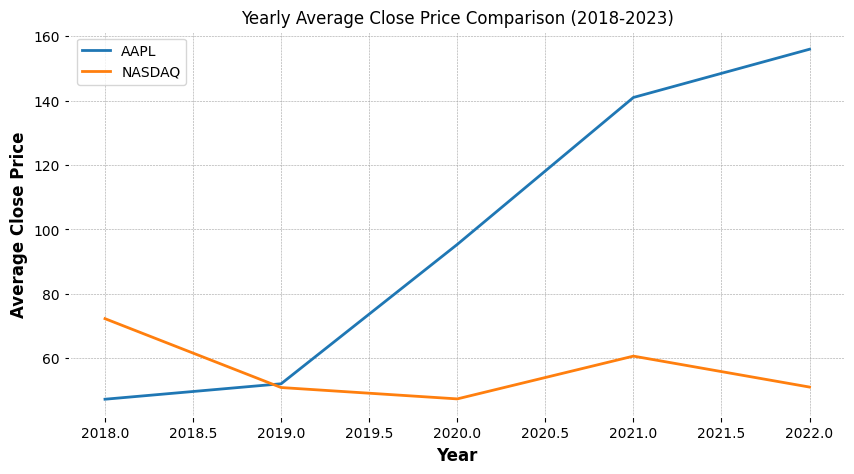

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
# Assuming df_nasdaq and df_sp500 are already loaded Spark DataFrames with the necessary columns
# Filter data for AAPL from df_nasdaq and all data from df_sp500, focusing on dates between 2018 and 2023
aapl_data = df_nasdaq.filter((col('Ticker') == 'AAPL') & (col('Date') >= '2018-01-01') & (col('Date') <= '2023-12-31'))
sp500_data = df_sp500.filter((col('Date') >= '2018-01-01') & (col('Date') <= '2023-12-31'))
nasdaq_data = df_nasdaq.filter((col('Date') >= '2018-01-01') & (col('Date') <= '2023-12-31'))

# Assuming that we need to compare the average 'Close' price yearly for visualization
aapl_yearly_avg = aapl_data.groupBy(year(col('Date')).alias('Year')).avg('Close').orderBy('Year')
sp500_yearly_avg = sp500_data.groupBy(year(col('Date')).alias('Year')).avg('Close').orderBy('Year')
nasdaq_yearly_avg = nasdaq_data.groupBy(year(col('Date')).alias('Year')).avg('Close').orderBy('Year')

# Collect data for plotting
aapl_plot_data = aapl_yearly_avg.collect()
sp500_plot_data = sp500_yearly_avg.collect()
nasdaq_plot_data = nasdaq_yearly_avg.collect()

# Extract years and average close prices
years = [x['Year'] for x in aapl_plot_data]  # assuming the years will be the same across all dataframes
aapl_prices = [x['avg(Close)'] for x in aapl_plot_data]
sp500_prices = [x['avg(Close)'] for x in sp500_plot_data]
nasdaq_prices = [x['avg(Close)'] for x in nasdaq_plot_data]

# Plotting the data
plt.figure(figsize=(10, 5))
plt.plot(years, aapl_prices, label='AAPL')
# plt.plot(years, sp500_prices, label='S&P 500')
plt.plot(years, nasdaq_prices, label='NASDAQ')

plt.title('Yearly Average Close Price Comparison (2018-2023)')
plt.xlabel('Year')
plt.ylabel('Average Close Price')
plt.legend()
plt.grid(True)
plt.show()


Due to COVID-19, AAPL stock experienced disruptions similar to the broader market. However, with more people staying indoors and increasingly depending on gadgets and services, AAPL witnessed significant growth in sales and content usage. Furthermore, Apple made its entry into the 5G arena with the launch of the iPhone 12 in October 2020. This release is seen as potentially initiating a robust upgrade cycle for the Cupertino-based company, with analysts estimating that approximately 40% of the global installed base might be ready for a new iPhone.

###9 Seasonal Analysis

#### 9.1 Are there any noticeable seasonal patterns of SP500 index?

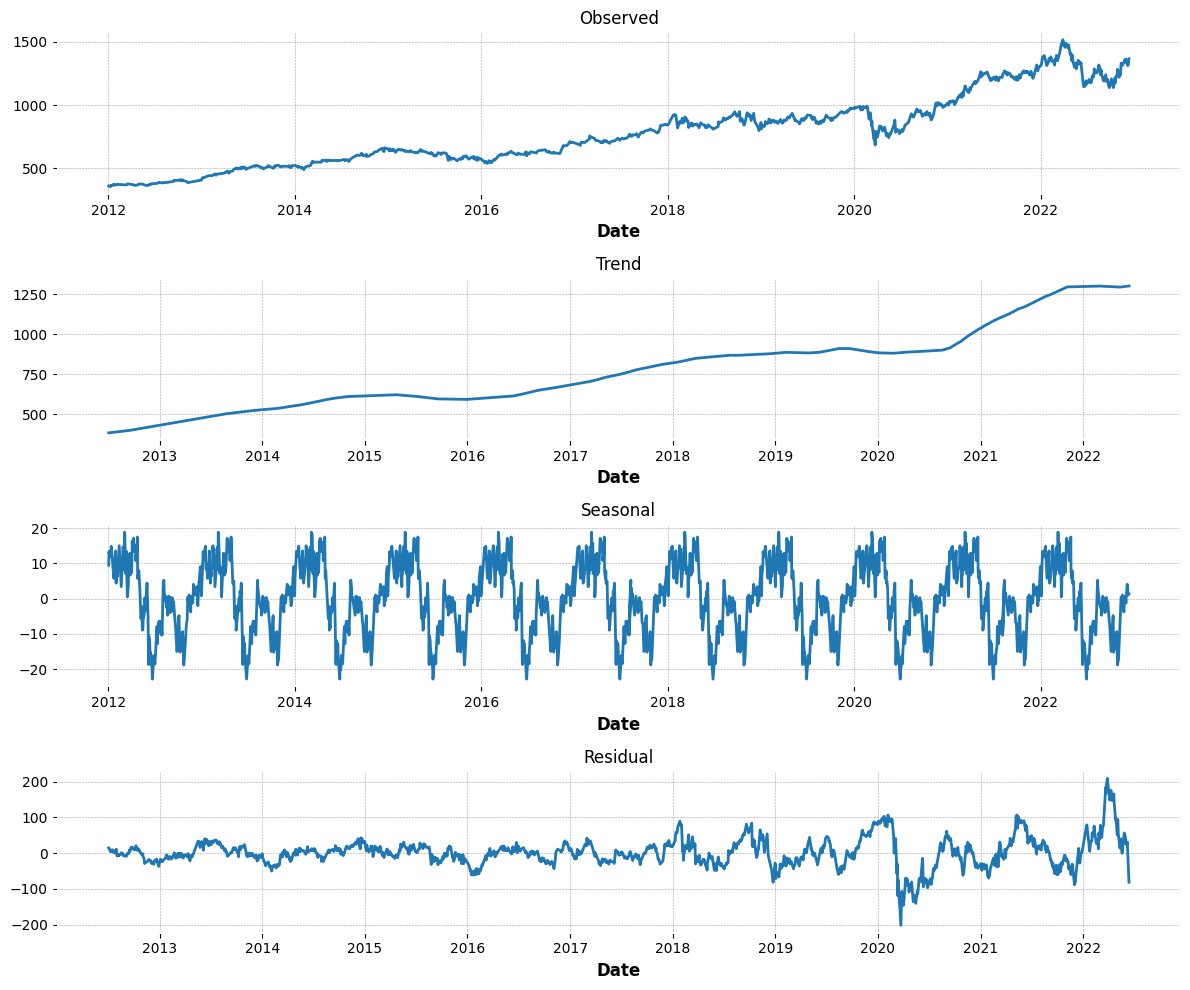

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd


# Convert the Date column to a proper date format first
df_sp500 = df_sp500.withColumn("Date", F.to_date(df_sp500["Date"], "dd-MM-yyyy"))

# Filter to include only data where Adjusted_Closesp500 is non-zero and dates between 2012 and 2022
df_sp500 = df_sp500.filter(
    (df_sp500['Adjusted_Close_sp500'] != 0) &
    (df_sp500['Date'] >= F.lit('2012-01-01')) &
    (df_sp500['Date'] <= F.lit('2022-12-31'))
).select('Date', 'Adjusted_Close_sp500')

# Calculate the daily average price
df_daily_avg = df_sp500.groupBy("Date").agg(F.avg("Adjusted_Close_sp500").alias("AvgPrice"))

# Collect the data into a Pandas DataFrame
pandas_df = df_daily_avg.toPandas()
pandas_df.sort_values('Date', inplace=True)
pandas_df.set_index('Date', inplace=True)

# Ensure data type is float (necessary for decomposition)
pandas_df['AvgPrice'] = pandas_df['AvgPrice'].astype(float)

# Decompose the time series using a daily frequency and annual seasonality (assuming 252 trading days per year)
decomposition = seasonal_decompose(pandas_df['AvgPrice'], model='additive', period=252)  # Adjust this if your data frequency differs

# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10))
decomposition.observed.plot(ax=ax1, title='Observed')
decomposition.trend.plot(ax=ax2, title='Trend')
decomposition.seasonal.plot(ax=ax3, title='Seasonal')
decomposition.resid.plot(ax=ax4, title='Residual')
plt.tight_layout()
plt.show()
df_sp500=df_sp500_copy

Observed (Top Chart):
This is the actual recorded data of the S&P 500 index over the given time period. There appears to be a general upward trend over the decade, with some fluctuations that could be attributed to market cycles or specific economic events.
Trend (Second Chart):
The trend component shows a smoothed curve representing the long-term progression of the data. There's a noticeable gradual increase over time, reflecting the overall growth of the S&P 500 index. Around 2016 to 2018 as well as 2021 to 2022 the trend shows a steeper incline, indicating a period of accelerated growth. Post-2020, the trend seems to plateau a bit, suggesting a slowing down in the rate of growth, which could reflect market responses to various global events such as the COVID-19 pandemic and its economic implications.
Seasonal (Third Chart):
The seasonal component captures the regular pattern within a year that repeats annually. It oscillates around the zero line, suggesting that there are consistent periods of higher and lower values within each year. This might correspond to certain market behaviors like end-of-year rallies or mid-year slumps that are commonly observed due to various factors including quarterly earnings reports, fiscal policies, and investor sentiment.
Residual (Bottom Chart):
The residual component represents the noise or irregularities in the data after the trend and seasonal components have been accounted for. It shows what might be considered the irregular or unpredictable 'shocks' to the system. The residual appears relatively stable and close to zero for most of the period, which indicates that the trend and seasonal components are capturing most of the structure of the data.
However, there are spikes of higher residuals at certain points, notably around 2020, which could be attributed to unexpected events such as the COVID-19 pandemic and the economic uncertainties that accompanied it.

####9.2 How does the average daily trading volume of SP500 vary over different quarters of the year?

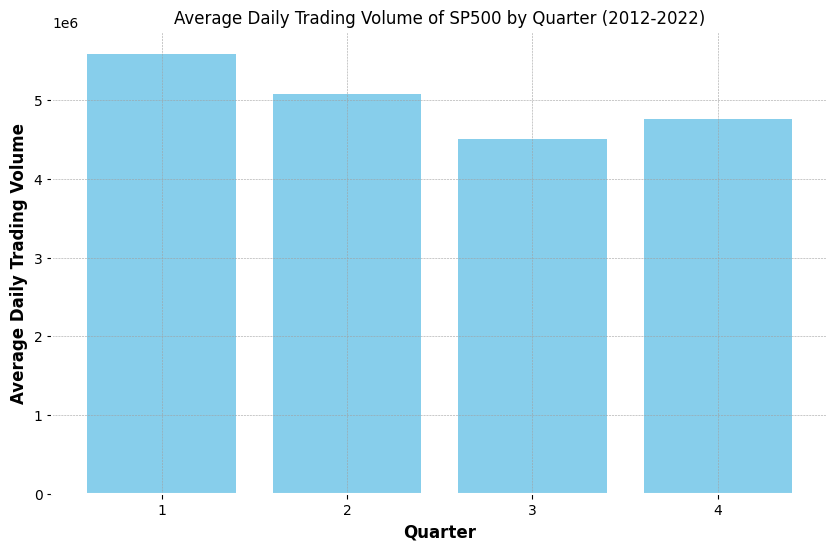

In [ ]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
df_market_filled = df_sp500
# Convert the Date column to the appropriate date type
df_market_filled = df_market_filled.withColumn("Date", F.to_date(df_market_filled["Date"], "dd-MM-yyyy"))

# Filter for dates between 2012 and 2022 and non-zero SP500 volume
df_sp500_volume = df_market_filled.filter(
    (df_market_filled['Date'] >= F.lit('2012-01-01')) &
    (df_market_filled['Date'] <= F.lit('2022-12-31')) &
    (df_market_filled['Adjusted_Close_sp500'] != 0)
).select('Date', 'Volume')

# Extract the quarter from the date
df_sp500_volume = df_sp500_volume.withColumn("Quarter", F.quarter("Date"))

# Group by quarter and calculate the average volume
df_quarterly_avg_volume = df_sp500_volume.groupBy("Quarter").agg(F.avg("Volume").alias("AvgVolume"))

# Collect the data to a Pandas DataFrame for visualization
pandas_df = df_quarterly_avg_volume.toPandas()

# Sort the data by quarter
pandas_df.sort_values('Quarter', inplace=True)

# Plot the average volume by quarter using a bar chart
plt.figure(figsize=(10, 6))
plt.bar(pandas_df['Quarter'].astype(str), pandas_df['AvgVolume'], color='skyblue')
plt.xlabel('Quarter')
plt.ylabel('Average Daily Trading Volume')
plt.title('Average Daily Trading Volume of SP500 by Quarter (2012-2022)')
plt.xticks(pandas_df['Quarter'].astype(str))
plt.show()


Q1: The first quarter has the highest average daily trading volume, showing that this period may typically see more trading activity. This could be due to new fiscal policies, year-end reports from the previous year, or new investment strategies being implemented.
Q2: The second quarter shows a slight decrease in volume compared to Q1. This may indicate a normalization of trading activity after the start of the fiscal year.
Q3: There is a further decrease in volume in the third quarter, which could suggest a seasonal pattern where trading volumes lower during the summer months when investors may be less active.
Q4: The volume in the fourth quarter shows a slight increase from Q3. This could be due to end-of-year financial positioning, such as closing books, tax-related selling, or investment adjustments for the new year.

###10 Stock Analysis

####10.1 Calculate Moving Average and Exponential MA

In [ ]:
df_aapl_2022.show(5)

+----------+------+------+------+------+---------+
|      Date|  Open|  High|   Low| Close|   Volume|
+----------+------+------+------+------+---------+
|2022-01-03|177.83|182.88|177.71|182.01|104487900|
|2022-01-04|182.63|182.94|179.12| 179.7| 99310400|
|2022-01-05|179.61|180.17|174.64|174.92| 94537600|
|2022-01-06| 172.7| 175.3|171.64| 172.0| 96904000|
|2022-01-07|172.89|174.14|171.03|172.17| 86709100|
+----------+------+------+------+------+---------+
only showing top 5 rows



In [ ]:
df_aapl_2022.show()

#### 10.2 Conduct a 50-day, 100-day, 200-day trend analysis to obser AAPL's closing price trend during 2019-2023 period.

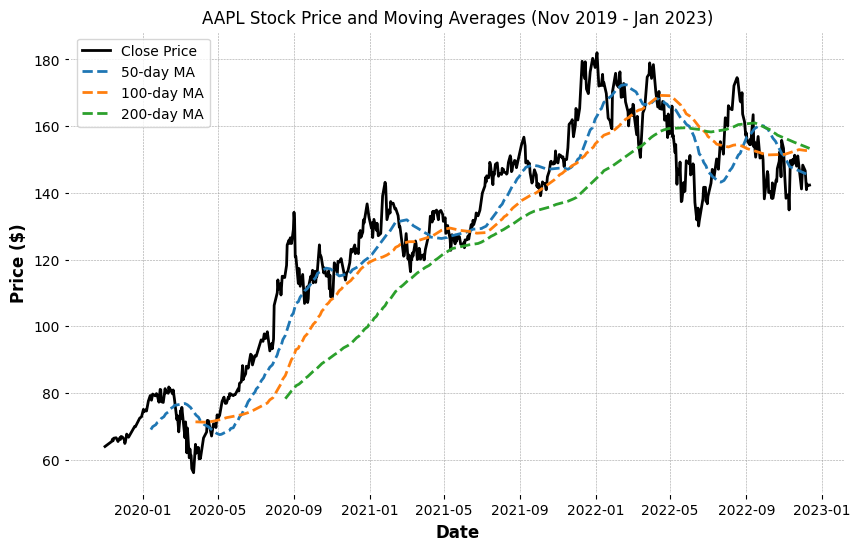

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df_nasdaq is already loaded with the necessary data

# Convert the 'Date' column to date type if not already
df_nasdaq = df_nasdaq.withColumn("Date", F.to_date(F.col("Date"), "yyyy-MM-dd"))

# Filter AAPL data from November 2019 to January 2023
df_aapl = df_nasdaq.filter(
    (F.col('Ticker') == 'AAPL') &
    (F.col('Date') >= F.lit('2019-11-01')) &
    (F.col('Date') <= F.lit('2023-01-31'))
).select('Date', 'Open', 'High', 'Low', 'Close', 'Volume').orderBy('Date')

# Convert to Pandas DataFrame for easier plotting
pandas_df = df_aapl.toPandas()
pandas_df['Date'] = pd.to_datetime(pandas_df['Date'])
pandas_df.set_index('Date', inplace=True)

# Calculate Moving Averages
pandas_df['MA50'] = pandas_df['Close'].rolling(window=50).mean()
pandas_df['MA100'] = pandas_df['Close'].rolling(window=100).mean()
pandas_df['MA200'] = pandas_df['Close'].rolling(window=200).mean()

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(pandas_df.index, pandas_df['Close'], label='Close Price', color='black')
plt.plot(pandas_df.index, pandas_df['MA50'], label='50-day MA', linestyle='--')
plt.plot(pandas_df.index, pandas_df['MA100'], label='100-day MA', linestyle='--')
plt.plot(pandas_df.index, pandas_df['MA200'], label='200-day MA', linestyle='--')

plt.title('AAPL Stock Price and Moving Averages (Nov 2019 - Jan 2023)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()


This code segment is tasked with filtering and preparing data pertaining to AAPL for analysis over the time period spanning 2021 to 2022. The code achieves this by filtering a pandas DataFrame to extract data specifically from these two years, 2021 and 2022. Subsequently, the filtered data is concatenated to create a comprehensive DataFrame, pandas_df_full_year, encapsulating both years' worth of stock data. The code then proceeds to calculate key indicators, namely the 50-day, 100-day, and 200-day moving averages (MA) based on the stock's closing prices throughout this period. These moving averages are pivotal indicators used in technical analysis to gauge trends and potential shifts in stock price movements over time. The subsequent plotting function generates a candlestick chart representing the closing prices over the combined 2021-2022 period, along with overlaid plots depicting the calculated moving averages. This visual representation offers traders and analysts a clear view of historical price trends and the behavior of the moving averages, aiding in the identification of potential signals for trading decisions. The addition of a legend and grid further enhances the plot's readability, providing clarity on the depicted lines and facilitating thorough analysis of the stock's performance across the specified timeframe. In summary, this code facilitates comprehensive stock analysis through the visualization of key price indicators and trends, supporting informed decision-making in trading strategies.

In [ ]:
def movingAvg(df,market=None, period=5):
    print(f"Calculating {period}-day Moving Average for {market}")
    windowSpec = Window.partitionBy("Ticker").orderBy("Date").rowsBetween(-1*(period-1), 0)  # For a 5-day moving average
    df = df.withColumn(f"{period}-day_moving_avg", F.avg("Close").over(windowSpec))
    df.show(5)
    print(f"Completed ...")
    return df


In [ ]:

df_nasdaq = movingAvg(df_nasdaq,"nasdaq",10)
# df_nyse = movingAvg(df_nyse,"nyse",10)

In [ ]:
# Show calculated metrics for a specific ticker, e.g., AAPL
df_nasdaq.filter(df_nasdaq.Ticker == "AAPL").select("Date", "Ticker", "Std_Dev_Returns", "ATR", "Relative_Volume").show()


###11 Volatility Analysis

In [ ]:
df_nasdaq.count()

In [ ]:
def calcVolatility(df, period, market=None):
    print(f"Calculating {period}-day Volatility for {market}")
    windowSpec = Window.partitionBy("Ticker").orderBy("Date")
    df = df.withColumn("log_return", log("Close") - log(lag("Close", 1).over(windowSpec)))
    windowVolatility = windowSpec.rowsBetween(-1*(period-1), 0)
    df = df.withColumn(f"{period}_day_volatility", F.stddev("log_return").over(windowVolatility))
    print("Completed ...")
    df.show()
    return df

In [ ]:
df_nasdaq = calcVolatility(df_nasdaq,3650,"nasdaq")
# df_nyse = calcVolatility(df_nyse,5,"nyse")

Calculating 3650-day Volatility for nasdaq
Completed ...
+------+----------+------+------+-------+------+------+---------------------+-----+----+----------+-------------+--------------------+--------------------+
|Ticker|      Date|   Low|  Open| Volume|  High| Close|Adjusted_Close_nasdaq|Month|Year|    Sector|      Country|          log_return| 3650_day_volatility|
+------+----------+------+------+-------+------+------+---------------------+-----+----+----------+-------------+--------------------+--------------------+
|  ACFN|1992-02-11|   4.5|   4.5|1509200|  5.25|5.0625|             4.885583|    2|1992|Technology|United States|                null|                null|
|  ACFN|1992-02-12| 4.875|5.0625| 869000|   5.5| 5.375|             5.187162|    2|1992|Technology|United States|  0.0598981415810691|                null|
|  ACFN|1992-02-13|4.9375|5.3125| 177000| 5.375|   5.0|            4.8252664|    2|1992|Technology|United States|-0.07232066157962636| 0.09349281231529707|
|  ACFN

Above we have calculated a 10 year rolling period volatility to observe the historical trends

#### 11.1 What are the stables stocks based on daily return and average volume of stock traded criteria?

In [ ]:
print("calculate daily return and average volume...")
df_nasdaq = df_nasdaq.withColumn('daily_return', (F.col('Close') - F.col('Open')) / F.col('Open'))

print("calculate avg vol...")
avg_volume = df_nasdaq.groupBy('Ticker').agg(F.avg('Volume').alias('avg_volume'))
avg_volume.createOrReplaceTempView("avg_volume_view")

print("calculate volatility...")
volatility_window = Window.partitionBy('Ticker')
df_nasdaq = df_nasdaq.withColumn('volatility', F.stddev('daily_return').over(volatility_window))

print("calc avg volatility...")
avg_volatility = df_nasdaq.groupBy('Ticker').agg(F.avg('volatility').alias('avg_volatility'))

# Join average volume with volatility
print("joining avg vol & volatility...")
avg_volatility = avg_volatility.join(avg_volume, "Ticker")
avg_volatility.createOrReplaceTempView("avg_volatility_view")

# SQL Query for the most stable stocks with a volume constraint
print("stable calc with volume constraint")
top_25_stable = spark.sql("""
    SELECT *
    FROM avg_volatility_view
    WHERE avg_volume > 1000000  -- Example volume threshold
    ORDER BY avg_volatility
    LIMIT 25
""")
top_25_stable.show()


calculate daily return and average volume...
calculate avg vol...


24/04/29 09:17:32 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


calculate volatility...
calc avg volatility...
joining avg vol & volatility...
stable calc with volume constraint


+------+--------------------+--------------------+
|Ticker|      avg_volatility|          avg_volume|
+------+--------------------+--------------------+
|  MDLZ|0.011678284803801389|   7562166.252310536|
|   VOD|0.013645543009915639|   4017274.054682955|
|   ADP|0.014378432137164195|  2062249.0733902394|
|    CS|0.014513391259062484|  1845017.6232718893|
|   PPG|0.015454944378697977|  1349341.7203562814|
|  CHTR| 0.01581690147701164|    1160520.68631062|
|   BCS|0.015975783629218886|  1741028.3429978117|
|  SSNC| 0.01604473106009821|  1026023.3304157549|
|     V|0.016165244771933405|1.5607831437348424E7|
|   WBA| 0.01621952794099064|  3795090.7670254223|
|  GRFS|0.016225576413253444|    1052672.22562866|
|  GLPI|  0.0162294093274943|  1171152.1720103987|
|  NWSA| 0.01624714520051919|   3131864.165759732|
|  ACGL| 0.01741308632036384|  1635186.5596209913|
|    MA|0.018134999024624374|1.1715659677465802E7|
|   AMX| 0.01820988485947703|  6573472.5593374595|
|  COST|0.018229044578353462|  

<b>MDLZ (Mondelez International):</b>
Sector: Consumer Goods
A global leader in snacks, Mondelez owns several major brands like Oreo, Cadbury, Nabisco, and Trident. The company's extensive product portfolio and global market presence offer substantial stability.

<b>VOD (Vodafone Group Plc):</b>
Sector: Telecommunications
One of the world's largest telecommunications companies, Vodafone provides a range of services including voice, messaging, data, and fixed communications. Its large subscriber base and operations in numerous countries contribute to its stability.

<b>ADP (Automatic Data Processing):</b>
Sector: Business Services
ADP is one of the largest providers of human resources management software and services in the world, which includes payroll, talent management, human resource management, benefits administration, and time and attendance.

<b>CS (Credit Suisse):</b>
Sector: Financial Services
A global investment bank and financial services firm based in Switzerland. Despite facing some recent challenges, Credit Suisse has a substantial presence in global financial markets.

<b>PPG (PPG Industries):</b>
Sector: Manufacturing
PPG Industries manufactures and distributes a range of paints, coatings, and specialty materials. The company serves various industries, including construction, consumer products, industrial, and transportation sectors.

<b>CHTR (Charter Communications):</b>
Sector: Telecommunications
Charter Communications is an American telecommunications and mass media company that offers its services to consumers and businesses under the branding of Spectrum. Providing services such as cable television, internet, telephone, and wireless services.

<b>BCS (Barclays PLC):</b>
Sector: Financial Services
Barclays is a British multinational bank and financial services company headquartered in London. It is a major global financial service provider engaged in personal banking, credit cards, corporate and investment banking, and wealth management.

<b>SSNC (SS and C Technologies):</b>
Sector: Technology
SS&C Technologies provides software and software-enabled services for the financial services and healthcare industries.

<b>V (Visa Inc.):</b>
Sector: Financial Services
Visa is one of the world's leading digital payments companies. Its technology facilitates digital funds transfers throughout the world, most commonly through Visa-branded credit and debit cards.

<b>WBA (Walgreens Boots Alliance):</b>
Sector: Retail Pharmacy and Health Wellness
Walgreens Boots Alliance is a leading global pharmacy-led, health, and wellbeing enterprise. It owns Walgreens and Boots, along with several pharmaceutical manufacturing, wholesale, and distribution companies.

<h4>Stability Assessment</h4>
These companies are large, established, and operate in diverse sectors, often as leaders in their fields. The stability in their stock prices (as suggested by low volatility) combined with high trading volumes indicates they are frequently traded yet do not experience extreme price fluctuations, which typically points to a solid investor confidence and robust business models.

These characteristics generally make them safer investment choices, particularly for investors looking for lower-risk opportunities in well-established companies

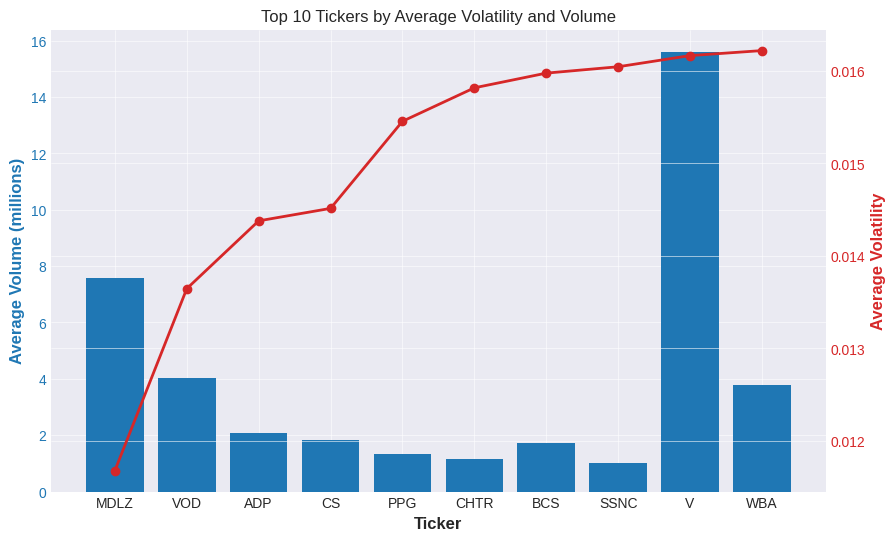

In [ ]:
df = top_25_stable

# Convert avg_volume to millions for easier interpretation
df = df.withColumn("avg_volume", col("avg_volume") / 1e6)

# Sort by avg_volatility and select the top 10
df_top10 = df.orderBy("avg_volatility").limit(10)

# Convert the sorted DataFrame to Pandas for plotting
pdf_top10 = df_top10.toPandas()

import matplotlib.pyplot as plt

# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for avg_volume
color = 'tab:blue'
ax1.set_xlabel('Ticker')
ax1.set_ylabel('Average Volume (millions)', color=color)
ax1.bar(pdf_top10['Ticker'], pdf_top10['avg_volume'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for avg_volatility
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Average Volatility', color=color)
ax2.plot(pdf_top10['Ticker'], pdf_top10['avg_volatility'], color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

# Title and show the plot
plt.title('Top 10 Tickers by Average Volatility and Volume')
plt.show()


Assuming that stocks with average volume > 1000000 and ascending average volatility are the criteria for stability in stocks, we get the above analysis. Notably, MDLZ being a consumer product manufacturer sees the best stability while V (Visa) company sees most price volatility amonst top 10 even with high volume of shares being traded.

As for the line chart, it shows the average volatility, with "V" again showing the highest value on this metric, suggesting that not only is it the most traded among the ten stocks in terms of volume, but it also experiences the most significant price fluctuations on average. All the other tickers follow with lower volatility, and they appear to have a relatively stable average volatility compared to "V".

It's also worth noting that the scale for average volatility is quite small (from 0.012 to 0.016), which implies that the stocks' price movements are not drastically volatile despite "V" being the highest among them.

The combination of high volume and high volatility for "V" could indicate a stock with significant investor interest and possibly larger price movements within the period studied, which may attract traders looking for active markets and potential trading opportunities. However, without more context such as the time frame of the data, market conditions, or company events, it's difficult to draw further conclusions from this chart alone.

#### VISA Data

In [ ]:
v_data = df_nasdaq.filter(df_nasdaq['Ticker'] == 'V')
v_data = v_data.withColumn('Date', F.col('Date').cast('date'))

import matplotlib.pyplot as plt

pandas_df_v = v_data.select('Date', 'log_return', '3650_day_volatility').toPandas()
plt.figure(figsize=(14, 7))

# Log Returns
plt.subplot(2, 1, 1)
plt.plot(pandas_df_v['Date'], pandas_df_v['log_return'], label='Log Returns', color='blue')
plt.title('V Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()

# Volatility
plt.subplot(2, 1, 2)
plt.plot(pandas_df_v['Date'], pandas_df_v['3650_day_volatility'], label='3650-Day Volatility', color='red')
plt.title('V 3650-Day Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
df_nasdaq = calcVolatility(df_nasdaq,252,"nasdaq")

In [ ]:
v_data = df_nasdaq.filter(df_nasdaq['Ticker'] == 'V')
v_data = v_data.withColumn('Date', F.col('Date').cast('date'))

import matplotlib.pyplot as plt

pandas_df_v = v_data.select('Date', 'log_return', '252_day_volatility').toPandas()
plt.figure(figsize=(14, 7))

# Log Returns
plt.subplot(2, 1, 1)
plt.plot(pandas_df_v['Date'], pandas_df_v['log_return'], label='Log Returns', color='blue')
plt.title('V Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()

# Volatility
plt.subplot(2, 1, 2)
plt.plot(pandas_df_v['Date'], pandas_df_v['252_day_volatility'], label='252-Day Volatility', color='red')
plt.title('V 252-Day Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()

plt.tight_layout()
plt.show()


#### AAAPL Data

In [ ]:
aapl_data = df_nasdaq.filter(df_nasdaq['Ticker'] == 'AAPL')
aapl_data = aapl_data.withColumn('Date', F.col('Date').cast('date'))

In [ ]:
aapl_data.show(5)

+------+----------+--------+--------+---------+--------+--------+---------------------+-----+----+----------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+--------------+-------------+------------+--------------------+-------------------+--------------------+
|Ticker|      Date|     Low|    Open|   Volume|    High|   Close|Adjusted_Close_nasdaq|Month|Year|    Sector|      Country|          log_return| 3650_day_volatility|        Daily_Return|          volatility|              Return|    High_Low|High_PrevClose|Low_PrevClose|  True_Range|          Avg_Volume|    Relative_Volume|        Stock_Return|
+------+----------+--------+--------+---------+--------+--------+---------------------+-----+----+----------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+--------------+-------------+------------+--------------------+----

####11.2 Give a historical analysis of AAPL stock to interpret any major event impacted changes in stock prices.

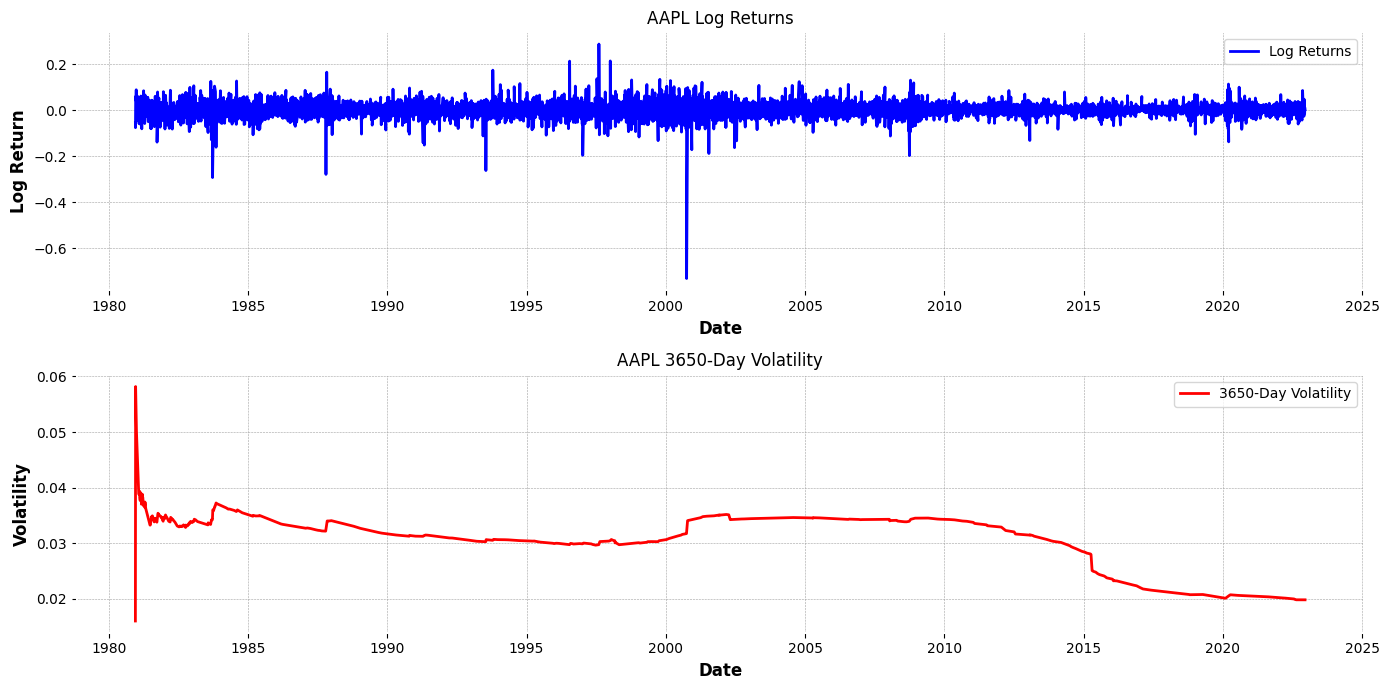

In [ ]:
import matplotlib.pyplot as plt

pandas_df = aapl_data.select('Date', 'log_return', '3650_day_volatility').toPandas()
plt.figure(figsize=(14, 7))

# Log Returns
plt.subplot(2, 1, 1)
plt.plot(pandas_df['Date'], pandas_df['log_return'], label='Log Returns', color='blue')
plt.title('AAPL Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()

# Volatility
plt.subplot(2, 1, 2)
plt.plot(pandas_df['Date'], pandas_df['3650_day_volatility'], label='3650-Day Volatility', color='red')
plt.title('AAPL 3650-Day Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()

plt.tight_layout()
plt.show()


<b>Top Chart: AAPL Log Returns</b>
Log is usually around zero, meaning no change from one day to the next. Positive values indicate a percentage increase in price from the previous day, while negative values indicate a percentage decrease. The plot's fluctuations show daily ups and downs in stock price. Large spikes (up or down) suggest significant one-day returns, whereas smaller oscillations represent days with less dramatic changes.
Notable features could include the high volatility during certain periods (like the large drop around 2000, which could correlate with the dot-com bubble burst) or more stable periods with smaller fluctuations in returns.


<b>Bottom Chart: AAPL 3650-Day Volatility</b>
The second chart shows measure of how much the stock's returns have varied over the preceding 10 years on any given day.
A higher volatility value suggests that the stock's returns were more dispersed (i.e., less consistent) over the past 10 years, which is typically seen as higher risk.
From the chart, we can see that AAPL's 10-year volatility was highest in the early years and has generally trended downwards over time, indicating that the stock's returns have become more stable on a decade-long timescale. The initial spike could be related to the company's earlier stage, when it was more susceptible to large fluctuations.
The overall decreasing trend might suggest that as AAPL matured as a company, its stock returns became more predictable, which is common for large, established companies compared to their earlier, more volatile years.

####11.3 What is the cause of extreme log return spike in AAPL stock?

In [ ]:
import pandas as pd
# Convert the 'Date' column to datetime if it's not already
pandas_df['Date'] = pd.to_datetime(pandas_df['Date'])

# Set the 'Date' column as the DataFrame's index
pandas_df.set_index('Date', inplace=True)

# Now you can filter by year
df_around_2000 = pandas_df[(pandas_df.index.year >= 1999) & (pandas_df.index.year <= 2001)]


# Calculate mean and standard deviation of the log returns for this period
mean_log_return = df_around_2000['log_return'].mean()
std_log_return = df_around_2000['log_return'].std()

# Identify returns that are more than 3 standard deviations away from the mean
threshold = 3
potential_outliers = df_around_2000[(df_around_2000['log_return'] < mean_log_return - threshold * std_log_return) |
                                    (df_around_2000['log_return'] > mean_log_return + threshold * std_log_return)]

print("Potential Outliers:\n", potential_outliers)


Potential Outliers:
             log_return  3650_day_volatility
Date                                       
2000-09-29   -0.731248             0.034000
2000-12-06   -0.172080             0.034341
2001-07-18   -0.188395             0.034997


https://money.cnn.com/2000/09/29/markets/techwrap/
https://www.dividend.com/how-to-invest/apples-worst-day-ever-aapl/#:~:text=September%2029%2C%202000%3A%20Apple%20Drops,deal%20with%20at%20the%20time.

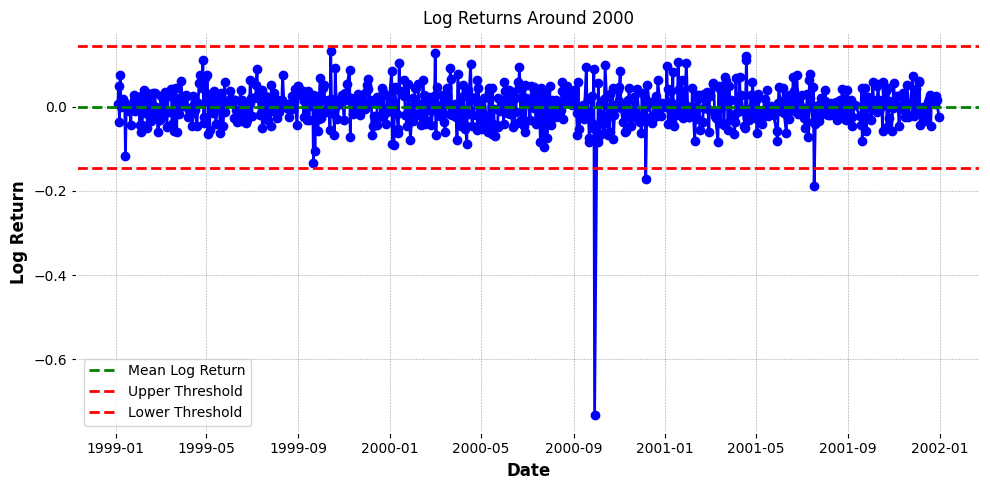

In [ ]:
import matplotlib.pyplot as plt

# Plot log returns around 2000
plt.figure(figsize=(10, 5))
plt.plot(df_around_2000['log_return'], marker='o', linestyle='-', color='blue')
plt.axhline(y=mean_log_return, color='green', linestyle='--', label='Mean Log Return')
plt.axhline(y=mean_log_return + threshold * std_log_return, color='red', linestyle='--', label='Upper Threshold')
plt.axhline(y=mean_log_return - threshold * std_log_return, color='red', linestyle='--', label='Lower Threshold')
plt.title('Log Returns Around 2000')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.tight_layout()
plt.show()


On the 29th of September 2000, there was a significant log return observed. Upon further analysis, it was discovered that Apple experienced a steep decline of 51.89%, likely as a result of the burst of the tech dot-com bubble.

For more information, please refer to the provided resources:

- A market summary from that date is available at CNN Money's website: [Tech market wrap](https://money.cnn.com/2000/09/29/markets/techwrap/).

- Details about Apple's drastic drop can be found at Dividend.com: [Apple's Worst Day Ever](https://www.dividend.com/how-to-invest/apples-worst-day-ever-aapl/#:~:text=September%2029%2C%202000%3A%20Apple%20Drops,deal%20with%20at%20the%20time).

###12 Relative Strength Index

####12.1 Conduct an analysis to measures the speed and change of price movements for AAPL

/opt/conda/miniconda3/lib/python3.10/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


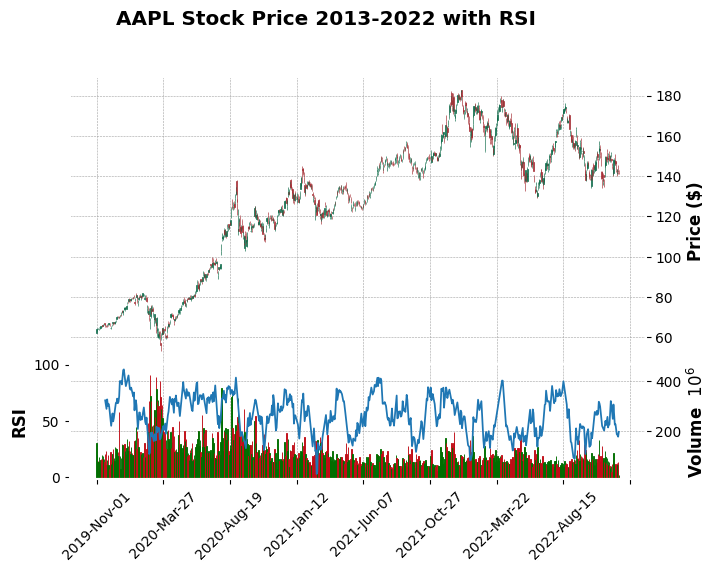

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import mplfinance as mpf
import pandas as pd

# Function to calculate RSI
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Filter for AAPL stock data from 2013 to 2022
df_aapl_2019_2022 = df_nasdaq.filter(
    (df_nasdaq['Ticker'] == 'AAPL') &
    (df_nasdaq['Date'] >= F.lit('2019-11-01')) &
    (df_nasdaq['Date'] <= F.lit('2022-12-31'))
).select('Date', 'Open', 'High', 'Low', 'Close', 'Volume').orderBy('Date')

# Convert to Pandas DataFrame for visualization
pandas_df = df_aapl_2019_2022.toPandas()

# Ensure the 'Date' column is a DatetimeIndex
pandas_df.set_index(pd.to_datetime(pandas_df['Date']), inplace=True)
pandas_df.drop(columns=['Date'], inplace=True)  # Remove the 'Date' column as it's now the index

# Calculate RSI
pandas_df['RSI'] = calculate_rsi(pandas_df)

# Check if DataFrame is empty
if pandas_df.empty:
    print("DataFrame is empty. Check data extraction and filtering steps.")
else:
    # Create a candlestick chart with RSI
    mpf.plot(pandas_df, type='candle', style='charles',
             title="AAPL Stock Price 2013-2022 with RSI",
             ylabel='Price ($)',
             volume=True,
             show_nontrading=False,
             addplot=[mpf.make_addplot(pandas_df['RSI'], panel=1, ylabel='RSI')])



The graph displays AAPL (Apple Inc.) stock price data alongside its Relative Strength Index (RSI) and trading volume over a period from 2013 to 2022.

The upper part of the graph shows the stock price movement, with prices plotted over time. The chart illustrates significant growth in the stock price, especially noticeable from around 2016 onwards, where a steep increase can be observed, followed by some volatility in the later years.

Below the price chart is the RSI, a momentum indicator that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock. The RSI appears to fluctuate above and below the mid-line (50 level), with excursions toward the extremes (0 and 100), which might suggest overbought or oversold conditions, respectively.

The volume of trades is represented at the very bottom of the graph, shown as vertical bars. This indicates how many shares of AAPL were traded on a daily basis. Periods of higher trading volume could be correlated with significant price moves or company events.

###13 Bollinger Bands

####13.1 What is the true and predicted trend of stocks pre-, during, post- COVID-19 period?

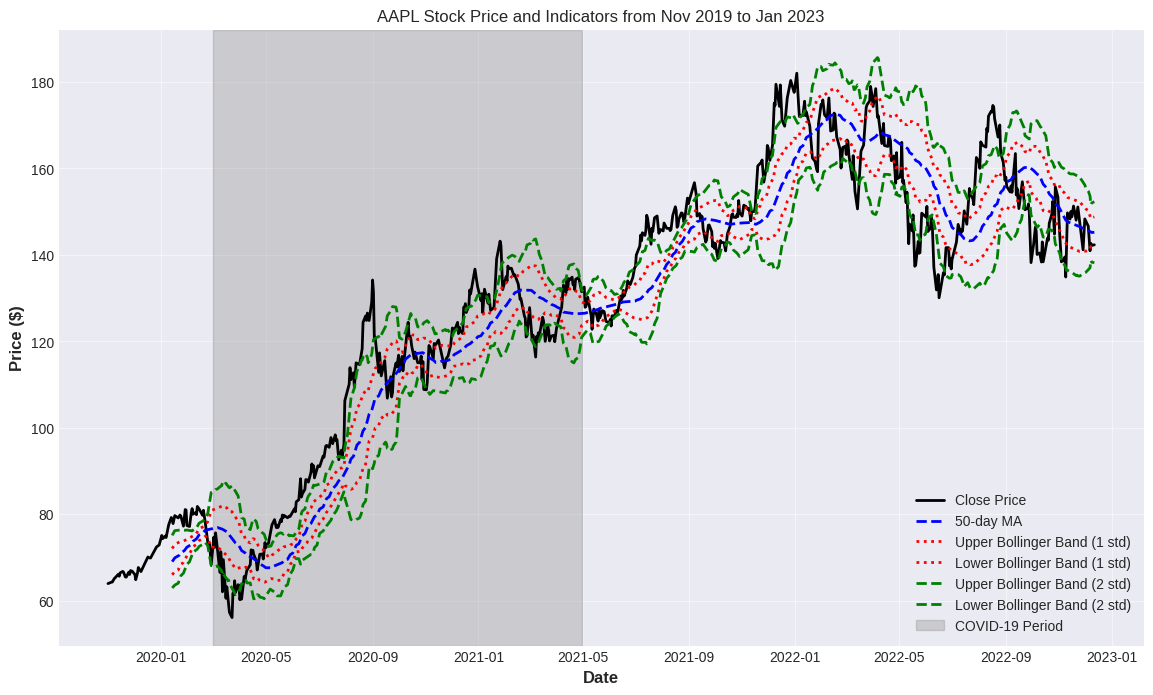

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import functions as F

# Ensure the Date column is the correct data type
df_nasdaq = df_nasdaq.withColumn("Date", F.to_date(df_nasdaq["Date"], "yyyy-MM-dd"))

# Filter AAPL data from Nov 2019 to Jan 2023
df_aapl = df_nasdaq.filter(
    (df_nasdaq['Ticker'] == 'AAPL') &
    (df_nasdaq['Date'] >= F.lit('2019-11-01')) &
    (df_nasdaq['Date'] <= F.lit('2023-01-31'))
).select('Date', 'Open', 'High', 'Low', 'Close', 'Volume').orderBy('Date')

# Convert to Pandas DataFrame for visualization
pandas_df = df_aapl.toPandas()
pandas_df.set_index(pd.to_datetime(pandas_df['Date']), inplace=True)
pandas_df.drop(columns=['Date'], inplace=True)  # Remove the 'Date' column as it's now the index

# Calculate Moving Averages and Bollinger Bands
pandas_df['MA50'] = pandas_df['Close'].rolling(window=50).mean()
pandas_df['MA100'] = pandas_df['Close'].rolling(window=100).mean()
pandas_df['MA200'] = pandas_df['Close'].rolling(window=200).mean()
pandas_df['stddev'] = pandas_df['Close'].rolling(window=20).std()
pandas_df['UpperBand_1std'] = pandas_df['MA50'] + (pandas_df['stddev'] * 1)
pandas_df['LowerBand_1std'] = pandas_df['MA50'] - (pandas_df['stddev'] * 1)
pandas_df['UpperBand_2std'] = pandas_df['MA50'] + (pandas_df['stddev'] * 2)
pandas_df['LowerBand_2std'] = pandas_df['MA50'] - (pandas_df['stddev'] * 2)

# Plotting
plt.figure(figsize=(14, 8))
plt.plot(pandas_df.index, pandas_df['Close'], label='Close Price', color='black')
plt.plot(pandas_df.index, pandas_df['MA50'], label='50-day MA', linestyle='--', color='blue')
plt.plot(pandas_df.index, pandas_df['UpperBand_1std'], label='Upper Bollinger Band (1 std)', linestyle=':', color='red')
plt.plot(pandas_df.index, pandas_df['LowerBand_1std'], label='Lower Bollinger Band (1 std)', linestyle=':', color='red')
plt.plot(pandas_df.index, pandas_df['UpperBand_2std'], label='Upper Bollinger Band (2 std)', linestyle='--', color='green')
plt.plot(pandas_df.index, pandas_df['LowerBand_2std'], label='Lower Bollinger Band (2 std)', linestyle='--', color='green')

# Highlight the COVID-19 period
plt.axvspan('2020-03-01', '2021-04-30', color='grey', alpha=0.3, label='COVID-19 Period')

plt.title('AAPL Stock Price and Indicators from Nov 2019 to Jan 2023')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()


This code snippet is preparing and displaying a comprehensive plot to analyze the price movements of a AAPL through  year 2019- 2023. The key features of the plot include the stock's closing prices depicted as a continuous line, allowing for an easy observation of price trends over time. Additionally, Bollinger Bands are overlaid on the plot to indicate potential upper and lower price boundaries based on standard deviations from the moving average of closing prices. The blue bands represent a 1-standard deviation range, while the red bands represent a 2-standard deviation range. This visualization is crucial for traders and analysts to assess volatility and potential trading opportunities. The legend and grid elements on the plot enhance its interpretability, providing clarity on the plotted lines and ensuring the data can be analyzed effectively. Overall, this code enables users to gain valuable insights into stock price dynamics and volatility, aiding in decision-making for trading strategies.

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, stddev, lit
from pyspark.sql.window import Window

# Assuming df_nasdaq is already loaded into a DataFrame
# df_nasdaq.show()

# Define a window spec for a rolling window of 20 days, ordered by the date
windowSpec = Window.partitionBy("Ticker").orderBy("Date").rowsBetween(-19, 0)

# Calculate the 20-day simple moving average (SMA) and the standard deviation
df_nasdaq = df_nasdaq.withColumn("SMA_20", avg("Close").over(windowSpec))
df_nasdaq = df_nasdaq.withColumn("STD_20", stddev("Close").over(windowSpec))

# Calculate the upper and lower Bollinger Bands
df_nasdaq = df_nasdaq.withColumn("Upper_Band", col("SMA_20") + (col("STD_20") * 2))
df_nasdaq = df_nasdaq.withColumn("Lower_Band", col("SMA_20") - (col("STD_20") * 2))

# Show results
df_nasdaq.select("Date", "Ticker", "Close", "SMA_20", "Upper_Band", "Lower_Band").show()


+----------+------+------+------------------+------------------+------------------+
|      Date|Ticker| Close|            SMA_20|        Upper_Band|        Lower_Band|
+----------+------+------+------------------+------------------+------------------+
|1992-02-11|  ACFN|5.0625|            5.0625|              null|              null|
|1992-02-12|  ACFN| 5.375|           5.21875| 5.660691738241592| 4.776808261758408|
|1992-02-13|  ACFN|   5.0| 5.145833333333333| 5.547652115041373| 4.744014551625293|
|1992-02-14|  ACFN|5.0625|             5.125| 5.463501600193165| 4.786498399806835|
|1992-02-18|  ACFN| 5.125|             5.125| 5.418150984988964| 4.831849015011036|
|1992-02-19|  ACFN|5.1875| 5.135416666666667| 5.402538673747077| 4.868294659586257|
|1992-02-20|  ACFN|   6.0| 5.258928571428571| 5.956500892308021| 4.561356250549121|
|1992-02-21|  ACFN|6.5625|          5.421875|  6.54737092243978|  4.29637907756022|
|1992-02-24|  ACFN|   6.0| 5.486111111111111| 6.607246448367253| 4.364975773

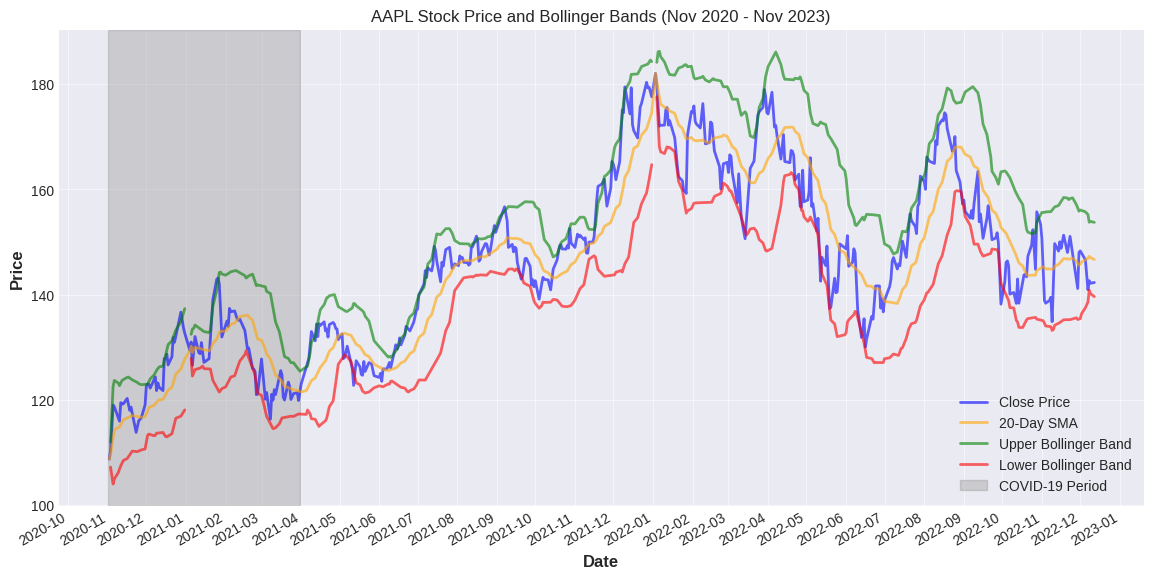

In [ ]:
from pyspark.sql.functions import year
from pyspark.sql import functions as F

# Assuming `df_nasdaq` has been loaded and filtered for the 'AAPL' ticker into `df_aapl`
# Filter for the date range from November 2018 to November 2023
df_aapl = df_aapl.filter((F.col("Date") >= F.lit("2020-11-01")) & (F.col("Date") <= F.lit("2023-11-30")))

# Continue with the window definition and Bollinger Band calculations as before

# Define the window spec for a rolling window of 20 days, partitioned by year for performance
windowSpec = Window.partitionBy(year(col("Date"))).orderBy("Date").rowsBetween(-19, 0)

# Calculate the 20-day simple moving average (SMA) and the standard deviation
df_aapl = df_aapl.withColumn("SMA_20", avg("Close").over(windowSpec))
df_aapl = df_aapl.withColumn("STD_20", stddev("Close").over(windowSpec))

# Calculate the upper and lower Bollinger Bands
df_aapl = df_aapl.withColumn("Upper_Band", col("SMA_20") + (col("STD_20") * 2))
df_aapl = df_aapl.withColumn("Lower_Band", col("SMA_20") - (col("STD_20") * 2))

# Create a new column 'YearMonth' for more granular partitioning
df_aapl = df_aapl.withColumn("YearMonth", year(col("Date")) * 100 + month(col("Date")))

# Redefine the window spec with the new 'YearMonth' partitioning
windowSpec = Window.partitionBy("YearMonth").orderBy("Date").rowsBetween(-19, 0)

# After computing Bollinger Bands in your PySpark DataFrame (assuming it's named `df_aapl`), collect the data to the driver node
aapl_pd = df_aapl.toPandas()
# Ensure your environment has Matplotlib installed
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert to a Pandas DataFrame
aapl_pd = df_aapl.toPandas()

# Set the plot size and style
plt.figure(figsize=(14, 7))
plt.style.use('seaborn-darkgrid')

# Filter the Pandas DataFrame for the plotting date range (already done in PySpark)
# aapl_pd = aapl_pd[(aapl_pd['Date'] >= '2020-11-01') & (aapl_pd['Date'] <= '2023-11-30')]

# Plot the Close Price, SMA, Upper Band, and Lower Band
plt.plot(aapl_pd['Date'], aapl_pd['Close'], label='Close Price', color='blue', alpha=0.6)
plt.plot(aapl_pd['Date'], aapl_pd['SMA_20'], label='20-Day SMA', color='orange', alpha=0.6)
plt.plot(aapl_pd['Date'], aapl_pd['Upper_Band'], label='Upper Bollinger Band', color='green', alpha=0.6)
plt.plot(aapl_pd['Date'], aapl_pd['Lower_Band'], label='Lower Bollinger Band', color='red', alpha=0.6)

# Highlight the COVID periods within the plotted range
plt.axvspan(*mdates.datestr2num(['2020-11-01', '2021-03-31']), color='grey', alpha=0.3, label='COVID-19 Period')

# Format the dates on the x-axis to show month and year
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # to get a tick every month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # includes year and month

# Optionally, you can use a minor locator to display an additional tick for months
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())

# Set the title and labels
plt.title('AAPL Stock Price and Bollinger Bands (Nov 2020 - Nov 2023)')
plt.xlabel('Date')
plt.ylabel('Price')

# Show legend
plt.legend()

# Rotate the dates on the x-axis for better readability
plt.gcf().autofmt_xdate()

# Show the plot
plt.show()

###14 Feature Engineering

#### 14.1 Beta score

Definition: Beta measures the volatility of a stock relative to the overall market. A beta greater than 1 indicates that the stock is more volatile than the market, while a beta less than 1 suggests it is less volatile.

Usage: Compare the beta values of different stocks to determine which are more likely to experience larger price fluctuations in response to market movements.

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Assuming df_sp500 is the S&P 500 index data and df_nasdaq contains individual stocks
df_sp500 = df_sp500.withColumn("Market_Return", (F.col("close") - F.col("open")) / F.col("open"))
df_nasdaq = df_nasdaq.withColumn("Stock_Return", (F.col("close") - F.col("open")) / F.col("open"))

# Join the dataframes on the date to align market and stock data
df_joined = df_nasdaq.join(df_sp500.select("date", "Market_Return"), "date", "inner")

# Calculate covariance and variance
covariance_df = df_joined.groupBy("ticker").agg(F.covar_samp("Stock_Return", "Market_Return").alias("covariance"))
market_variance = df_sp500.agg(F.var_samp("Market_Return").alias("market_variance")).collect()[0]["market_variance"]

# Calculate Beta for each stock
beta_df = covariance_df.withColumn("Beta", F.col("covariance") / market_variance)
beta_df = beta_df.orderBy(beta_df.Beta.asc())
beta_df.show(10)

filtered_beta_df = beta_df.filter((F.col("Beta") > 0) & (F.col("Beta") <= 1))

# Order by Beta in ascending order and take the top 10
top_10_stocks = filtered_beta_df.orderBy("Beta").limit(10)

# Show the results
top_10_stocks.show()


#### Standard Deviation of Return


Definition: This statistical measure represents the variability or volatility of stock price returns over a specific period. It provides a sense of how much the stock price fluctuates from its average price.

Usage: Lower standard deviation values indicate less price volatility, thus suggesting greater stability.

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Calculate daily returns
df_nasdaq = df_nasdaq.withColumn("Daily_Return", (F.col("close") - F.col("open")) / F.col("open"))

# Calculate standard deviation of daily returns for each stock
std_dev_returns = df_nasdaq.groupBy("ticker").agg(F.stddev("Daily_Return").alias("Std_Dev_Returns"))
std_dev_returns = std_dev_returns.orderBy(std_dev_returns.Std_Dev_Returns.asc())
std_dev_returns.show(10)


#### 14.2 Average True Range


Definition: ATR is a technical analysis indicator that measures market volatility by decomposing the entire range of an asset price for that period. It provides a more comprehensive measure of volatility than simple price fluctuations.

Usage: It helps in understanding the volatility of stocks over a specified period, with lower ATR indicating less volatility and potentially more stability.

In [ ]:
# Calculate components of True Range
df_nasdaq = df_nasdaq.withColumn("High_Low", F.col("high") - F.col("low"))
df_nasdaq = df_nasdaq.withColumn("High_PrevClose", F.abs(F.col("high") - F.lag("close", 1).over(Window.partitionBy("ticker").orderBy("Date"))))
df_nasdaq = df_nasdaq.withColumn("Low_PrevClose", F.abs(F.col("low") - F.lag("close", 1).over(Window.partitionBy("ticker").orderBy("Date"))))

# Calculate True Range
df_nasdaq = df_nasdaq.withColumn("True_Range", F.greatest("High_Low", "High_PrevClose", "Low_PrevClose"))

# Calculate Average True Range
atr = df_nasdaq.groupBy("ticker").agg(F.avg("True_Range").alias("ATR"))
atr = atr.orderBy(atr.ATR.asc())
atr.show(10)

#### Relative Volume

Measures current trading volume in comparison to historical trading volume, providing insights into unusual trading activity.

In [ ]:
# Define window for calculating moving average volume
windowSpec = Window.partitionBy("ticker").orderBy("Date").rowsBetween(-10, -1)

# Calculate moving average of volume
df_nasdaq = df_nasdaq.withColumn("Avg_Volume", F.avg("volume").over(windowSpec))

# Calculate Relative Volume
df_nasdaq = df_nasdaq.withColumn("Relative_Volume", F.col("volume") / F.col("Avg_Volume"))



For stock stability:
1. Low Beta (<1): Stocks with a beta less than 1 are considered less volatile than the market, indicating more stability. A beta close to 0 suggests very little correlation with market movements.

2. Low Standard Deviation: This indicates that the stock's returns are less spread out from the mean, suggesting more predictable performance and less price volatility.

3. Low ATR: A lower ATR indicates that the stock's price does not fluctuate dramatically in a short period, pointing to steadiness in its price movements.

4. Consistent Relative Volume: Extreme spikes in trading volume can indicate instability. Stocks with more consistent and moderate relative volume might be considered more stable.


## **Tweet Data**

### 15.1 Loading Tweet Data

In [ ]:
bucket = spark._jsc.hadoopConfiguration().get("fs.gs.system.bucket")
data = "gs://bucket_stocks/notebooks/jupyter/stock_market/".format(bucket)

tweet_src1_1_schema = StructType([StructField("tweet_id", StringType(), True),
                            StructField("ticker_symbol", StringType(), True)])

tweet_src1_2_schema= StructType([StructField("tweet_id", StringType(), True),
                            StructField("writer", StringType(), True),
                            StructField("postdate", IntegerType(), True ),
                            StructField("body", StringType(), True),
                            StructField("comment_num", StringType(), True),
                            StructField("retweet_num", StringType(), True  ),
                            StructField("like_num", StringType(), True )])

tweet_src2_schema= StructType([StructField("id", StringType(), True),
                            StructField("text", StringType(), True),
                            StructField("timestamp", StringType(), True ),
                            StructField("source", StringType(), True),
                            StructField("symbols", StringType(), True),
                            StructField("company_names", StringType(), True  ),
                            StructField("url", StringType(), True ),
                            StructField("verified", StringType(), True )])


In [ ]:

### Loading first tweet data
tweet_src1_1 = spark.read.format("csv")\
  .option("header", "true")\
  .schema(tweet_src1_1_schema)\
  .load(data + "Tweet_from_companies/Company_Tweet.csv")

tweet_src1_1.printSchema()
tweet_src1_1.show(5)
print("----------------------------------------")
tweet_src1_2 = spark.read.format("csv")\
  .option("header", "true")\
  .schema(tweet_src1_2_schema)\
  .load(data + "Tweet_from_companies/Company_Tweet_data.csv")
tweet_src1_2 = tweet_src1_2.withColumn("postdate", to_date(from_unixtime("postdate")))

tweet_src1_2.printSchema()
tweet_src1_2.show(5)
print("----------------------------------------")

print("combining first source...")

tweet_src1 = tweet_src1_2.join(tweet_src1_1, tweet_src1_2.tweet_id == tweet_src1_1.tweet_id, "left").drop(tweet_src1_1.tweet_id)
tweet_src1.show(5)



root
 |-- tweet_id: string (nullable = true)
 |-- ticker_symbol: string (nullable = true)



+------------------+-------------+
|          tweet_id|ticker_symbol|
+------------------+-------------+
|550803612197457920|         AAPL|
|550803610825928706|         AAPL|
|550803225113157632|         AAPL|
|550802957370159104|         AAPL|
|550802855129382912|         AAPL|
+------------------+-------------+
only showing top 5 rows

----------------------------------------
root
 |-- tweet_id: string (nullable = true)
 |-- writer: string (nullable = true)
 |-- postdate: date (nullable = true)
 |-- body: string (nullable = true)
 |-- comment_num: string (nullable = true)
 |-- retweet_num: string (nullable = true)
 |-- like_num: string (nullable = true)

+------------------+-------------+----------+--------------------+-----------+-----------+--------+
|          tweet_id|       writer|  postdate|                body|comment_num|retweet_num|like_num|
+------------------+-------------+----------+--------------------+-----------+-----------+--------+
|553669644209618945|   NASDAQODUK|2

+------------------+-------------+----------+--------------------+-----------+-----------+--------+-------------+
|          tweet_id|       writer|  postdate|                body|comment_num|retweet_num|like_num|ticker_symbol|
+------------------+-------------+----------+--------------------+-----------+-----------+--------+-------------+
|553669644209618945|   NASDAQODUK|2015-01-09|$AMZN - When the ...|          0|          0|       0|         AMZN|
|553670366472581120|OphirGottlieb|2015-01-09|$GOOGL Down Grade...|          0|          0|       1|        GOOGL|
|553670366472581120|OphirGottlieb|2015-01-09|$GOOGL Down Grade...|          0|          0|       1|         MSFT|
|553670406822199298|Wicked_Trader|2015-01-09|$AMZN - When the ...|          0|          0|       0|         AMZN|
|553670428758388737|  scottidiego|2015-01-09|$AMZN - When the ...|          0|          0|       0|         AMZN|
+------------------+-------------+----------+--------------------+-----------+----------

In [ ]:

### loading second tweet data
from pyspark.sql.functions import to_timestamp
tweet_src2 = spark.read.format("csv")\
  .option("header", "true")\
  .schema(tweet_src2_schema)\
  .load(data + "Tweet_from_companies/stockerbot-export.csv")

spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

# with strings like 'Wed Jul 18 21:33:26 +0000 2018'
# First, convert 'timestamp' to a timestamp type, then to a date type
tweet_src2 = tweet_src2.withColumn("date", to_date(to_timestamp(col("timestamp"), "EEE MMM dd HH:mm:ss Z yyyy")))

tweet_src2.printSchema()
tweet_src2.show(5)

root
 |-- id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- source: string (nullable = true)
 |-- symbols: string (nullable = true)
 |-- company_names: string (nullable = true)
 |-- url: string (nullable = true)
 |-- verified: string (nullable = true)
 |-- date: date (nullable = true)

+-------------------+--------------------+--------------------+------------+-------+-----------------+--------------------+--------+----------+
|                 id|                text|           timestamp|      source|symbols|    company_names|                 url|verified|      date|
+-------------------+--------------------+--------------------+------------+-------+-----------------+--------------------+--------+----------+
|1019696670777503700|VIDEO: “I was in ...|Wed Jul 18 21:33:...|GoldmanSachs|     GS|The Goldman Sachs|https://twitter.c...|    True|2018-07-18|
|1019709091038548000|The price of lumb...|Wed Jul 18 22:22:...|  StockTwits|

### 15.2 Cleaning Tweet Data

In [ ]:

tweet_src1=tweet_src1.drop('writer','comment_num','retweet_num','like_num')
tweet_src1 = tweet_src1.withColumnRenamed("postdate", "Date") \
                   .withColumnRenamed("body", "Body") \
                   .withColumnRenamed("ticker_symbol", "Ticker")

tweet_src1.show(5)
print("------------------------------")


+------------------+----------+--------------------+------+
|          tweet_id|      Date|                Body|Ticker|
+------------------+----------+--------------------+------+
|553669644209618945|2015-01-09|$AMZN - When the ...|  AMZN|
|553670366472581120|2015-01-09|$GOOGL Down Grade...| GOOGL|
|553670366472581120|2015-01-09|$GOOGL Down Grade...|  MSFT|
|553670406822199298|2015-01-09|$AMZN - When the ...|  AMZN|
|553670428758388737|2015-01-09|$AMZN - When the ...|  AMZN|
+------------------+----------+--------------------+------+
only showing top 5 rows

------------------------------


In [ ]:
tweet_src2=tweet_src2.drop('source','company_names','url','verified','timestamp')
tweet_src2 = tweet_src2.withColumnRenamed("id", "tweet_id") \
                               .withColumnRenamed("text", "body") \
                               .withColumnRenamed("symbols", "Ticker") \
                               .withColumnRenamed("date", "Date")
tweet_src2.show(5)

+-------------------+--------------------+------+----------+
|           tweet_id|                body|Ticker|      Date|
+-------------------+--------------------+------+----------+
|1019696670777503700|VIDEO: “I was in ...|    GS|2018-07-18|
|1019709091038548000|The price of lumb...|     M|2018-07-18|
|1019711413798035500|Who says the Amer...|   AIG|2018-07-18|
|1019716662587740200|Barry Silbert is ...|   BTC|2018-07-18|
|1019718460287389700|How satellites av...|  ORCL|2018-07-18|
+-------------------+--------------------+------+----------+
only showing top 5 rows



### 15.3 Combining both tweet sources

In [ ]:
df_tweets = tweet_src1.unionByName(tweet_src2)

### 15.4 Removing null and Outliers

In [ ]:
df_tweets = df_tweets.na.drop()
df_tweets = df_tweets.where(df_tweets.tweet_id != 555357843491405825)
# df_tweets.show(10)

In [ ]:
df_tweets_copy=df_tweets

In [ ]:
# df_tweets.toPandas()

In [ ]:
df=df_tweets
# Convert Date column to proper date type
df = df.withColumn("Date", to_date(col("Date"), "dd-MM-yyyy"))
print(f"Adding month...")
df = df.withColumn("Month", month("Date"))
print(f"Adding year...")
df = df.withColumn("Year", year("Date"))
df.show(5)

Adding month...
Adding year...


+------------------+----------+--------------------+------+-----+----+
|          tweet_id|      Date|                Body|Ticker|Month|Year|
+------------------+----------+--------------------+------+-----+----+
|553669644209618945|2015-01-09|$AMZN - When the ...|  AMZN|    1|2015|
|553670366472581120|2015-01-09|$GOOGL Down Grade...| GOOGL|    1|2015|
|553670366472581120|2015-01-09|$GOOGL Down Grade...|  MSFT|    1|2015|
|553670406822199298|2015-01-09|$AMZN - When the ...|  AMZN|    1|2015|
|553670428758388737|2015-01-09|$AMZN - When the ...|  AMZN|    1|2015|
+------------------+----------+--------------------+------+-----+----+
only showing top 5 rows



In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Assuming 'spark' is your SparkSession and 'df_tweets' is your PySpark DataFrame
df_tweets=df
# Group by the 'Year' column and count the number of tweets per year
tweet_counts_by_year = df_tweets.groupBy("Year").count()

# Rename the count column to something more descriptive
tweet_counts_by_year = tweet_counts_by_year.withColumnRenamed("count", "tweet_count")

# Sort the results by year for better readability
tweet_counts_by_year = tweet_counts_by_year.orderBy("Year")

# Show the counts of tweets per year
tweet_counts_by_year.show()

+----+-----------+
|Year|tweet_count|
+----+-----------+
|2015|       7786|
|2018|      28867|
+----+-----------+



In [ ]:
# df_2015 = df_tweets.filter(year("Date") == 2015)
total_frequencies = df_tweets.groupBy("Ticker").count().withColumnRenamed("count", "TotalFrequency")

top_10_tickers = total_frequencies.orderBy(col("TotalFrequency").desc()).limit(10)

# Join the top 10 tickers back to the original dataset to filter it
top_10_df = df_tweets.join(top_10_tickers.select("Ticker"), "Ticker")

# Show the result (for verification or further processing)
top_10_df.show()


+------+------------------+----------+--------------------+-----+----+
|Ticker|          tweet_id|      Date|                Body|Month|Year|
+------+------------------+----------+--------------------+-----+----+
|  AAPL|553700537720270849|2015-01-09|$AAPL analyzing t...|    1|2015|
|  AAPL|553700406094987266|2015-01-09|Is $Aapl of 2015,...|    1|2015|
|  AAPL|553699734854987777|2015-01-09|$AAPL i'm long Ja...|    1|2015|
|  AAPL|553697051569971200|2015-01-09|"""@alphatrends: ...|    1|2015|
|  AAPL|553696991281045505|2015-01-09|HomeKit at CES: I...|    1|2015|
|  AAPL|553695221007929344|2015-01-09|Apple Should Post...|    1|2015|
|  AAPL|553694677300297728|2015-01-09|#FridayPortfolio ...|    1|2015|
|  AAPL|553694602012528642|2015-01-09|"The Electronic F...|    1|2015|
|  AAPL|553693773256220672|2015-01-09|Methodical approa...|    1|2015|
|  AAPL|553693586362224640|2015-01-09|@BloombergRadio J...|    1|2015|
|  AAPL|553693573372456961|2015-01-09|Apple Pay in Brow...|    1|2015|
|  AAP

In [ ]:
top_10_tickers.show(10)

+------+--------------+
|Ticker|TotalFrequency|
+------+--------------+
|  AAPL|          3351|
|  TSLA|          1428|
|  GOOG|          1121|
|  AMZN|           870|
| GOOGL|           860|
|  MSFT|           370|
|  NFLX|           101|
|   MTB|           100|
|  AMAT|           100|
|    ES|           100|
+------+--------------+



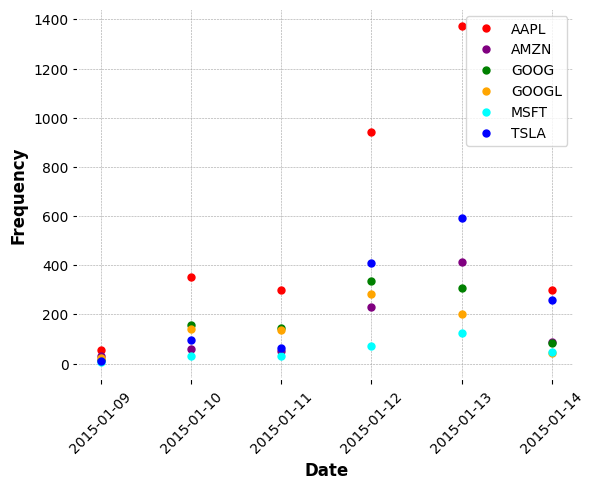

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
top_10_df=top_10_df.filter(top_10_df['Year']==2015)
# Convert 'Date' to a date type
top_10_df = top_10_df.withColumn("Date", col("Date").cast("date"))

# Group by 'Date' and 'Ticker', count occurrences
df_grouped = top_10_df.groupBy("Date", "Ticker").count().withColumnRenamed("count", "Frequency")

# Collect the data to the driver for plotting
df_pandas = df_grouped.toPandas()

# Plotting
fig, ax = plt.subplots()
colors = {
    'AAPL': 'red',     # Apple Inc
    'TSLA': 'blue',    # Tesla, Inc
    'GOOG': 'green',   # Alphabet Inc. (Google) - Class C
    'AMZN': 'purple',  # Amazon.com, Inc
    'GOOGL': 'orange', # Alphabet Inc. (Google) - Class A
    'MSFT': 'cyan',    # Microsoft Corporation
    'NFLX': 'magenta', # Netflix, Inc
    'MTB': 'lime',     # M&T Bank
    'ES': 'brown',     # Eversource Energy
    'AMAT': 'pink'      # Applied Materials Inc.
}


# Plot each group with its own color
for ticker, group in df_pandas.groupby('Ticker'):
    ax.plot(group['Date'], group['Frequency'], marker='o', linestyle='', ms=5, label=ticker, color=colors[ticker])

ax.set_xlabel('Date')
ax.set_ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend()
plt.show()

This graph appears to represent the frequency of tweets related to certain stocks over a series of dates. The vertical axis shows the frequency, indicating the number of tweets, while the horizontal axis shows the dates, spread across January 2015. The different colors represent different stocks: AAPL (Apple Inc.), AMZN (Amazon.com Inc.), GOOG (Alphabet Inc. - Class C), GOOGL (Alphabet Inc. - Class A), MSFT (Microsoft Corporation), and TSLA (Tesla Inc.).

Each colored dot represents the tweet frequency for that stock on a particular date. For example, red dots represent the frequency of tweets about Apple. A dot higher on the graph indicates a higher number of tweets about that stock on that day. The distribution of dots may suggest varying levels of public interest or significant events affecting those companies during that period.

On certain days, such as around January 13th, there's a noticeable increase in tweet frequency for most of the stocks, which could imply a market event or news that impacted several technology companies simultaneously. The clustering of dots at the bottom suggests days of lower social media activity for these stocks.

In [ ]:
# get list of all tickers

unique_tickers_df = df_tweets.select("Ticker").distinct()
unique_tickers_list = [row.Ticker for row in unique_tickers_df.collect()]

# Printing the unique tickers
print(unique_tickers_list)


['AAPL', 'TSLA', 'GOOG', 'GOOGL', 'AMZN', 'MSFT', 'ALXN', 'GIS', 'K', 'AVY', 'AIV', 'PPG', 'MMM', 'RF', 'IRM', 'WEC', 'CI', 'INFO', 'PM', 'BLK', 'ETE', 'UA', 'ESRX', 'EA', 'OXY', 'MTD', 'TROW', 'HAS', 'MAT', 'TSM', 'DDR', 'XL', 'ticker', 'EMN', 'KIM', 'EVHC', 'RE', 'PRU', 'TSN', 'CLX', 'FRT', 'BMY', 'XOM', 'MCHP', 'ADI', 'PHM', 'AMZN-GPS', 'ODP', 'HDS', 'ROP', 'SYY', 'JNPR', 'CHRW', 'AGN', 'RTN', 'SPG', 'ZBH', 'HIBB', 'ITUB', 'HOLX', 'GILD', 'OKE', 'CCL', 'QCOM', 'NOV', 'PNC', 'PBR', 'NTRS', 'WFT', 'NVAX', 'CINF', 'EOG', 'VIPS', 'WFC', 'HSY', 'AABA', 'TWX', 'ABX', 'SIRI', 'PRGO', 'MPC', 'MNK', 'CMS', 'GGP', 'DHR', 'SPN', 'KSU', 'BSX', 'MUR', 'GNCA', 'ERIC', 'UHS', 'XRX', 'ACN', 'COP', 'T', 'AIG', 'UDR', 'WU', 'LYB', 'INTC', 'MRK', 'NEE', 'EMR', 'GG', 'APH', 'PG', 'HP', 'NUAN', 'FMSA', 'CX', 'DVN', 'WYN', 'ROST', 'INTU', 'WY', 'EXR', 'EQIX', 'JD', 'MCD', 'INTC-USB', 'DHI', 'CTAS', 'ANSS', 'IFF', 'BDX', 'SWN', 'ABEV', 'ABBV', 'XEC', 'NLY', 'RAD', 'ADP', 'KMB', 'AAP', 'TMK', 'KMX', 'HES',

### 15.5 What are the top companies with social presence?

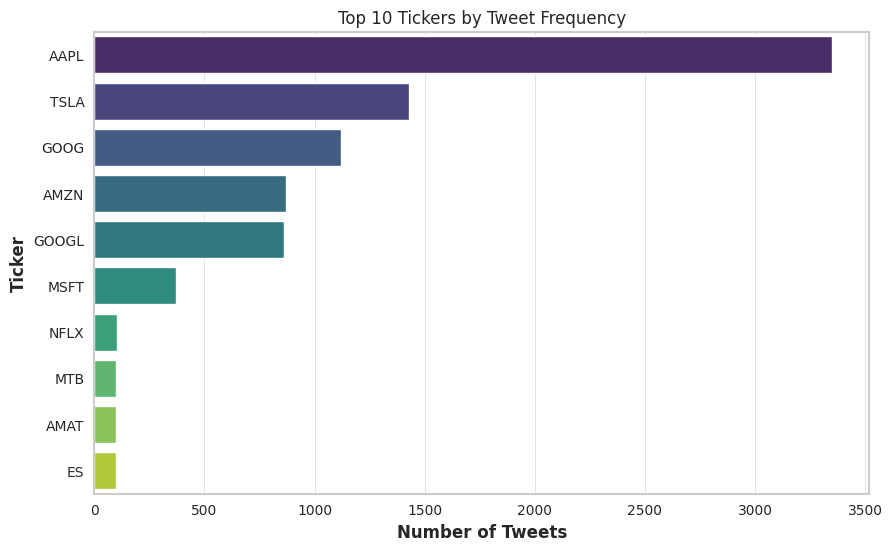

In [ ]:
from pyspark.sql.functions import col, count

# Count tweets by Ticker
tweet_counts = df_tweets.groupBy("Ticker").agg(count("*").alias("TweetCount"))

# Get the top 10 tickers by tweet count
top_10_tweet_counts = tweet_counts.orderBy(col("TweetCount").desc()).limit(10)
top_10_pd = top_10_tweet_counts.toPandas()
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="TweetCount", y="Ticker", data=top_10_pd, palette="viridis", orient="h")

# Enhance the plot
plt.title('Top 10 Tickers by Tweet Frequency')
plt.xlabel('Number of Tweets')
plt.ylabel('Ticker')

# Show plot
plt.show()

'AAPL' (Apple Inc.) stands out with the highest number of tweets, which indicates a significant amount of discussion or interest on social media. This could be attributed to product launches, earnings reports, or other company news. 'TSLA' (Tesla, Inc.) also shows a large number of tweets, suggesting a strong public interest or market activity. This could be driven by news related to electric vehicles, Elon Musk's statements, or Tesla's market performance. The presence of 'GOOG' (Alphabet Inc., Google's parent company) and 'AMZN' (Amazon.com, Inc.) suggests that major tech companies generally have a higher tweet frequency, possibly reflecting their larger market presence and active news cycle.
Comparison between Competitors: There is a visible difference between 'GOOG' and 'GOOGL', despite them both representing Alphabet Inc.'s stock, traded as Class C and Class A shares, respectively. This could indicate a difference in investor or public discussions surrounding each share class.
Other Notable Companies: 'MSFT' (Microsoft Corporation), 'NFLX' (Netflix, Inc.), and 'AMAT' (Applied Materials, Inc.) have a substantial presence, indicating they were also the subject of frequent discussions, possibly due to product announcements, quarterly earnings, or other significant corporate events.

### 15.6 Sentiment Analysis

In [ ]:
!pip install nltk textblob

In [ ]:
from pyspark.sql import SparkSession
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from pyspark.sql.functions import udf, col
from pyspark.sql.types import FloatType

# Initialize NLTK VADER
import nltk
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:

# Define UDF for NLTK VADER
def sentiment_score(text):
    print("returning sentiment score...")
    return sia.polarity_scores(text)['compound']

sentiment_score_udf = udf(sentiment_score, FloatType())


In [ ]:

print("Applying sentiment analysis on the tweet text...")
df_tweets = df_tweets.withColumn("sentiment_score", sentiment_score_udf(col("Body")))


df_tweets.select("tweet_id", "Date", "Body", "Ticker", "sentiment_score").show()


Applying sentiment analysis on the tweet text...


+------------------+----------+--------------------+------+---------------+
|          tweet_id|      Date|                Body|Ticker|sentiment_score|
+------------------+----------+--------------------+------+---------------+
|553669644209618945|2015-01-09|$AMZN - When the ...|  AMZN|            0.0|
|553670366472581120|2015-01-09|$GOOGL Down Grade...| GOOGL|           0.34|
|553670366472581120|2015-01-09|$GOOGL Down Grade...|  MSFT|           0.34|
|553670406822199298|2015-01-09|$AMZN - When the ...|  AMZN|            0.0|
|553670428758388737|2015-01-09|$AMZN - When the ...|  AMZN|            0.0|
|553670917197279232|2015-01-09|Sell = $AMZN, $AN...|  AMZN|            0.0|
|553672565273530369|2015-01-09|The Storage Lawsu...|  MSFT|        -0.2263|
|553672736191836162|2015-01-09|There it went. “@...|  AAPL|            0.0|
|553672792374136832|2015-01-09|$AAPL stroooong C...|  AAPL|            0.0|
|553672887681695744|2015-01-09|$AAPL man i beat ...|  AAPL|         0.4404|
|55367309800

In [ ]:
from pyspark.sql.functions import avg
# Ensure the date format is consistent
stocks_df = df_nasdaq
tweets_df = df_tweets
tweets_df = tweets_df.withColumn("Date", to_date(col("Date"), "yyyy-MM-dd"))
stocks_df = stocks_df.withColumn("Date", to_date(col("Date"), "yyyy-MM-dd"))

# Join the dataframes on Date and Ticker
combined_df = tweets_df.join(stocks_df, ["Date", "Ticker"], "inner")

# Calculate average sentiment score for each ticker and date
avg_sentiment = combined_df.groupBy("Date", "Ticker").agg(avg("sentiment_score").alias("avg_sentiment"))

# Calculate daily stock price change
combined_df = combined_df.withColumn("Daily Change", col("Close") - col("Open"))

# Show results
avg_sentiment.show()
combined_df.select("Date", "Ticker", "Daily Change", "avg_sentiment").show()


+----------+------+--------------------+
|      Date|Ticker|       avg_sentiment|
+----------+------+--------------------+
|2018-07-18|  BBBY| 0.06653809547424316|
|2018-07-13|   MAR| 0.01685454493219202|
|2018-07-17|  ALGN| 0.18302608540524606|
|2018-07-12|  GNTX|-0.05303333202997843|
|2018-07-12|   SLM| 0.10919999910725488|
|2018-07-17|  INTU| 0.16005000099539757|
|2018-07-17|  COST|  0.1245263148295252|
|2018-07-17|    ON| 0.06378000043332577|
|2018-07-18|  TROW|0.021719998121261595|
|2018-07-11|  HIBB|                 0.0|
|2018-07-18|   AAL| 0.07281154012068725|
|2018-07-12|  QRVO|-0.02662857089723...|
|2018-07-13|  SNPS| 0.16768333812554678|
|2018-07-17|  JBHT|  0.2666021268418495|
|2018-07-12|   ODP|                 0.0|
|2018-07-17|  NTAP|                 0.0|
|2018-07-18|  YNDX|                 0.0|
|2018-07-11|   ODP| 0.19645000621676445|
|2018-07-11|  GNCA|                 0.0|
|2018-07-16|  IDXX| 0.05594761793812116|
+----------+------+--------------------+
only showing top

In [ ]:
stocks_df = df_nasdaq
tweets_df = df_tweets
tweets_df = tweets_df.withColumn("Date", to_date(col("Date"), "yyyy-MM-dd"))
stocks_df = stocks_df.withColumn("Date", to_date(col("Date"), "yyyy-MM-dd"))

# Join the dataframes on Date and Ticker
combined_df = tweets_df.join(stocks_df, ["Date", "Ticker"], "inner")

In [ ]:
combined_df.show(5)

+----------+------+-------------------+--------------------+-----+----+---------------+-----+-----+-------+-----+-----+---------------------+-----+----+
|      Date|Ticker|           tweet_id|                Body|Month|Year|sentiment_score|  Low| Open| Volume| High|Close|Adjusted_Close_nasdaq|Month|Year|
+----------+------+-------------------+--------------------+-----+----+---------------+-----+-----+-------+-----+-----+---------------------+-----+----+
|2018-07-18|  BBBY|1019675953549791200|#NASDAQ Biggest %...|    7|2018|            0.0|18.41|19.13|3940600|19.16|18.72|            17.021877|    7|2018|
|2018-07-18|  BBBY|1019649345577259000|RT @15minofPham: ...|    7|2018|            0.0|18.41|19.13|3940600|19.16|18.72|            17.021877|    7|2018|
|2018-07-18|  BBBY|1019643329162743800|$BBBY is followin...|    7|2018|            0.0|18.41|19.13|3940600|19.16|18.72|            17.021877|    7|2018|
|2018-07-18|  BBBY|1019641010341605400|Mid-day trading r...|    7|2018|           

#### Show the distribution of sentiment score of tweets and stock prices overtime for a comparitive analyses

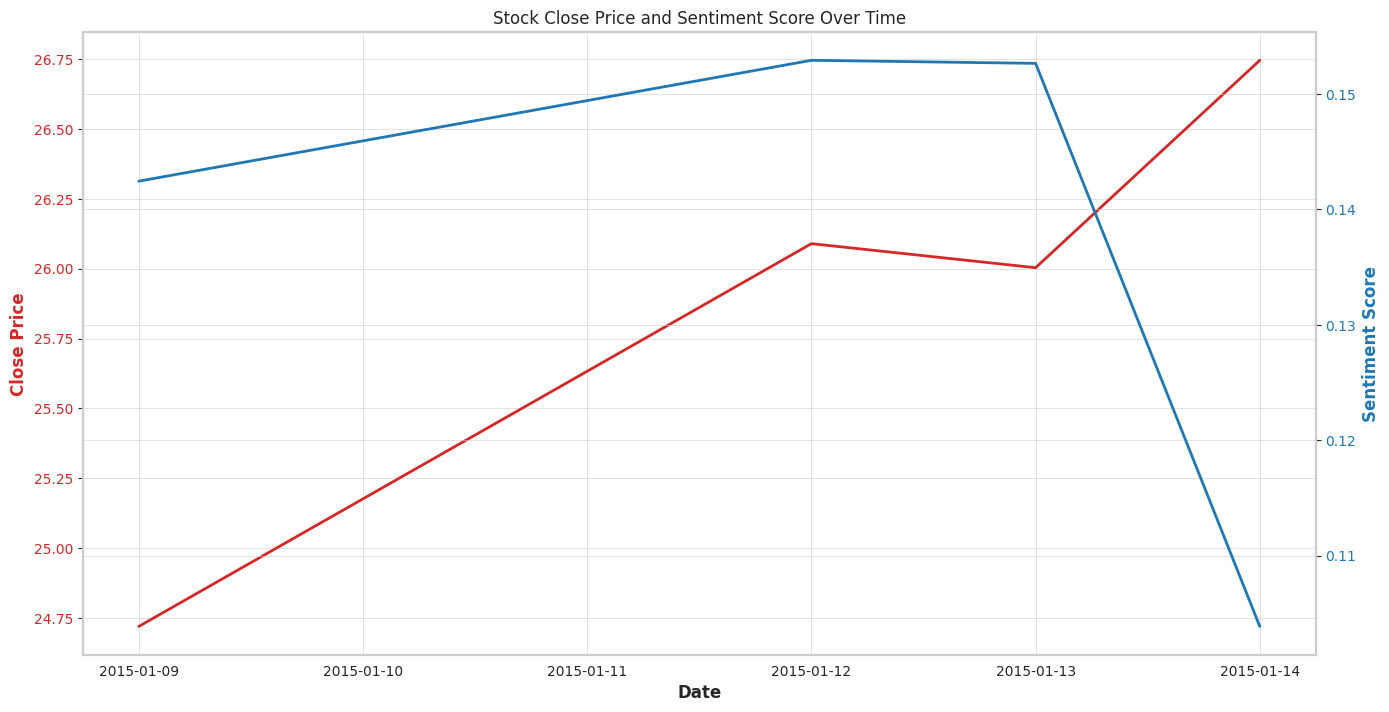

In [ ]:
import matplotlib.pyplot as plt

# Let's assume 'combined_df' is already loaded as a Pandas DataFrame
# Make sure that 'Date' is a datetime type and 'Close' and 'sentiment_score' are floats

combined_df = combined_df.toPandas()
combined_df['Date'] = pd.to_datetime(combined_df['Date'])
combined_df['Close'] = combined_df['Close'].astype(float)
combined_df['sentiment_score'] = combined_df['sentiment_score'].astype(float)


# Aggregate the data by date to get average sentiment score and close price for each day
aggregated_data = combined_df.groupby('Date').agg({'Close': 'mean', 'sentiment_score': 'mean'}).reset_index()
aggregated_data_copy=aggregated_data
# Assuming 'Year' is a column in `aggregated_data`
aggregated_data = aggregated_data[(aggregated_data['Date'] > '2014-12-31') & (aggregated_data['Date'] < '2016-01-01')]


# Plotting
fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color=color)
ax1.plot(aggregated_data['Date'], aggregated_data['Close'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Sentiment Score', color=color)
ax2.plot(aggregated_data['Date'], aggregated_data['sentiment_score'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # to ensure the right y-label is not slightly clipped
plt.title('Stock Close Price and Sentiment Score Over Time')
plt.show()


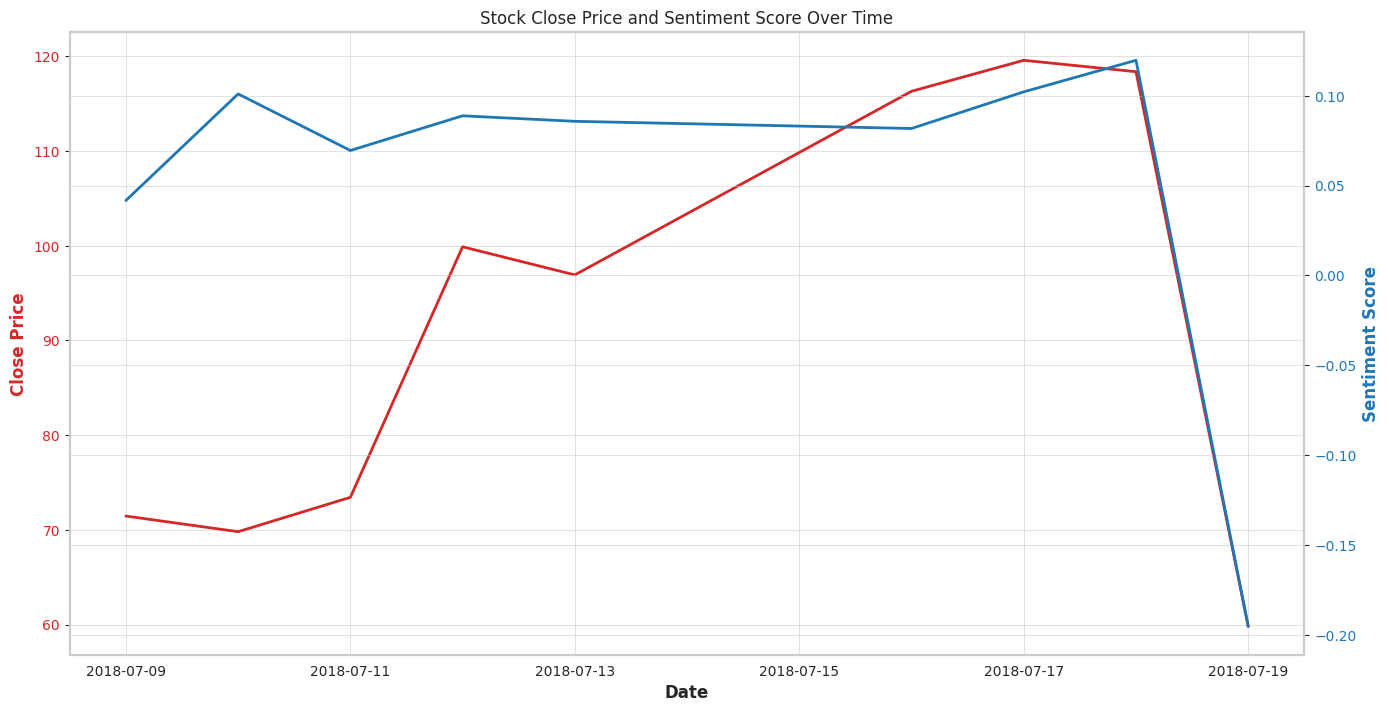

In [ ]:
import matplotlib.pyplot as plt

# Let's assume 'combined_df' is already loaded as a Pandas DataFrame
# Make sure that 'Date' is a datetime type and 'Close' and 'sentiment_score' are floats

# combined_df = combined_df.toPandas()
combined_df['Date'] = pd.to_datetime(combined_df['Date'])
combined_df['Close'] = combined_df['Close'].astype(float)
combined_df['sentiment_score'] = combined_df['sentiment_score'].astype(float)

# Aggregate the data by date to get average sentiment score and close price for each day
aggregated_data = combined_df.groupby('Date').agg({'Close': 'mean', 'sentiment_score': 'mean'}).reset_index()
# Assuming 'Year' is a column in `aggregated_data`
aggregated_data = aggregated_data[(aggregated_data['Date'] > '2015-12-31') & (aggregated_data['Date'] < '2023-01-01')]


# Plotting
fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color=color)
ax1.plot(aggregated_data['Date'], aggregated_data['Close'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Sentiment Score', color=color)
ax2.plot(aggregated_data['Date'], aggregated_data['sentiment_score'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # to ensure the right y-label is not slightly clipped
plt.title('Stock Close Price and Sentiment Score Over Time')
plt.show()


#### How much is there correlation between the sentiment score and the opening/closing prices of the stocks?

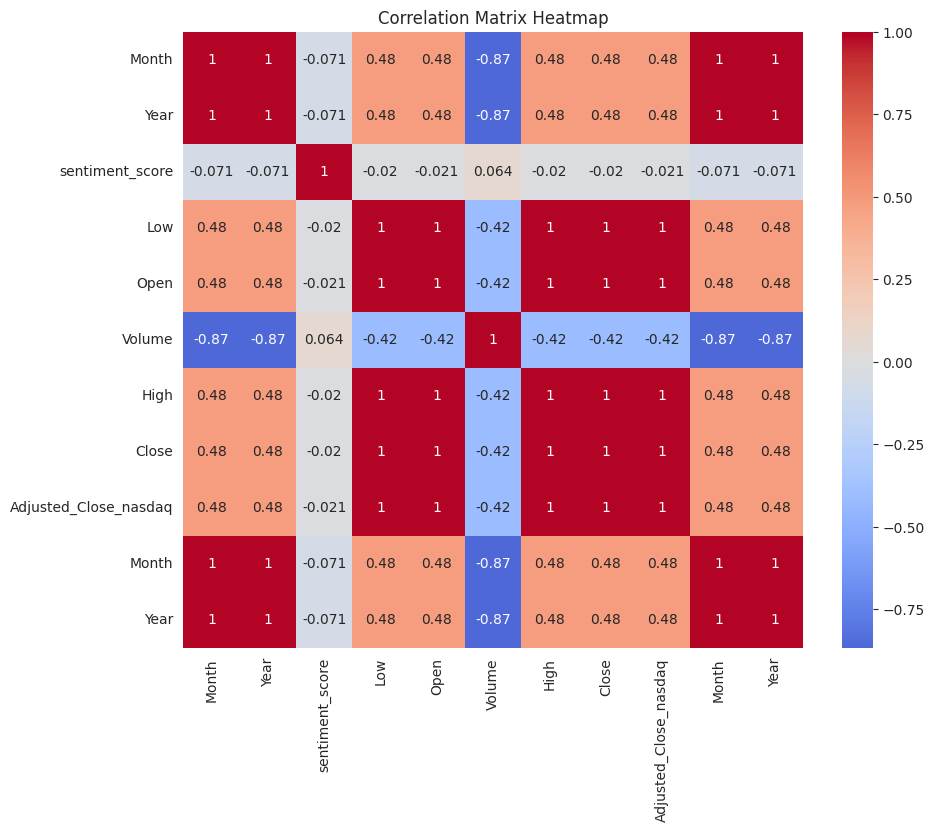

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'dataframe' is your pandas DataFrame that contains both the stock metrics and sentiment scores
# Example columns in dataframe: 'Close', 'Volume', 'Sentiment_Score', etc.

# First, calculate the correlation matrix
correlation_matrix = combined_df.corr()

# Now, plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap')
plt.show()


We can observe that:

The sentiment score appears to have very little to no linear correlation with the stock prices and trading volumes. This suggests that, at least in this data set, sentiment score may not be a significant predictor of stock price movements.

The 'Low', 'Open', 'High', 'Close', and 'Adjusted_Close_nasdaq' variables are perfectly correlated with each other (correlation of 1), which is expected since they are all measures of stock price and tend to move together within the same trading day.

The strong correlation between high, low, opening, and closing prices, as well as the adjusted close (all around 0.48), indicates a consistent trading pattern. However, a deeper time series analysis might be required to draw more substantive conclusions about trading patterns.

## Machine Learning

###16 Logistic Regression

In [ ]:
df_nyse=df_nyse_copy

In [ ]:
# Importing necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from pyspark.sql import SparkSession

In [ ]:
# Step 1: Data Preprocessing
# Filter data for the desired company ticker
company_ticker = "IBM"
company_data = df_nyse.filter(df_nyse["Ticker"] == company_ticker)
company_data = company_data.withColumn("Date", company_data["Date"].cast("date"))
company_data = company_data.dropna()

# Step 2: Feature Engineering
# Extract relevant features from the date column
company_data = company_data.withColumn("Year", F.year("Date"))
company_data = company_data.withColumn("Month", F.month("Date"))


pandas_df = company_data.toPandas()


In [ ]:
numerical_features = ["Low", "Volume", "High", "Adjusted_Close_nyse", "nyse_avg_daily_return", "nyse_volatility", "nyse_avg_volume", "Year", "Month"]
categorical_features = ["Sector", "Country"]

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Compute predicted probabilities
y_probs = classification_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc = roc_auc_score(y_test, y_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

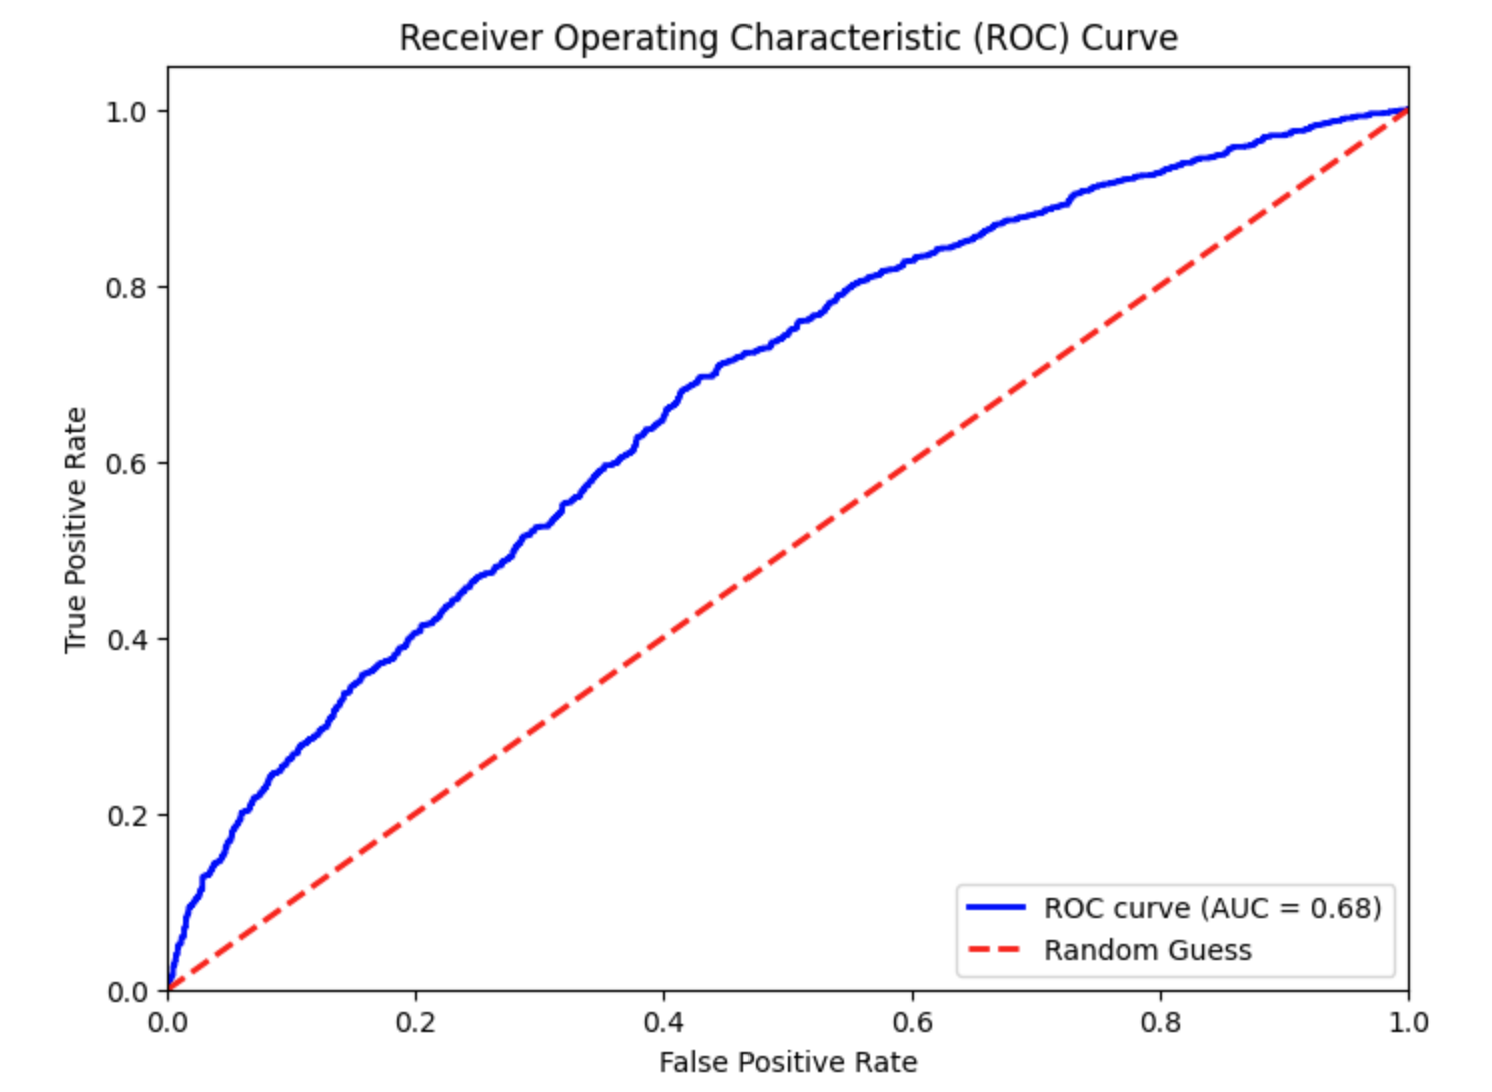

In [ ]:
# Define preprocessing steps
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()
# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [ ]:
# Append classifier to preprocessing pipeline
# Now we can fit the full pipeline
classification_model = Pipeline(steps=[('preprocessor', preprocessor),
                                       ('classifier', LogisticRegression())])


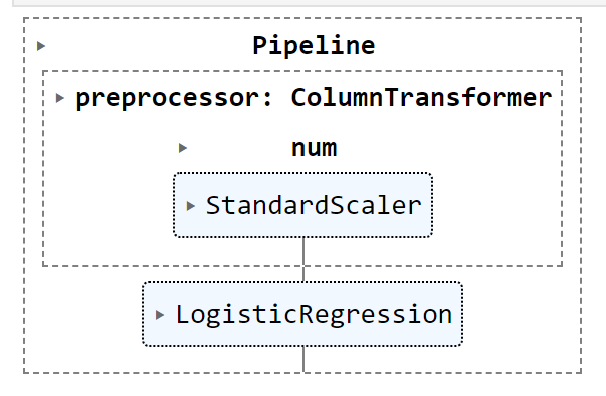

In [ ]:
#  Split Data
X = pandas_df.drop(columns=["Ticker", "Date", "Open"])
# Convert 'Open' to binary labels: 1 for increase, 0 for decrease or same
y = (pandas_df["Open"].diff() > 0).astype(int).fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Logistic Regression Classification
# Train the logistic regression classification model
classification_model.fit(X_train, y_train)


In [ ]:
# Make predictions on the test set
y_pred = classification_model.predict(X_test)

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

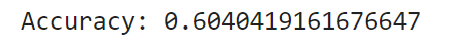

####**Hyperparameter Tunning**

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters grid
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(classification_model, param_grid, cv=5, scoring='accuracy')

# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with best hyperparameters:", accuracy)


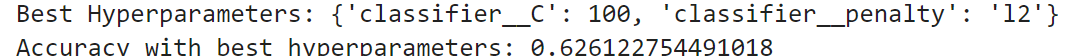

The logistic regression model shows slight change in performance before and after hyperparameter tuning, indicating that the grid search did not yield substantial improvements. The balanced accuracy remains at 60%, suggesting an equal consideration of both classes. The grid search did not find alternative hyperparameters significantly different from the initial settings.

<a id="part7"></a>
## 7. Challenges
----------
Challenges:
Working on a big data project focused on stock prices over the last 40 years for major exchanges like S&P 500, NASDAQ, NYSE, and Russell 2000 presents several challenges related to managing and processing large volumes of data. Here are some key difficulties that our group faced in this project:

1. Data Volume and Scalability: One of the primary challenges in this big data project was handling massive volumes of data. Stock market data, especially over a 40-year period and across multiple exchanges, amounted to gigabytes of raw information. This required robust infrastructure and scalable technologies to store, process, and analyze the data efficiently.


2. Data Collection and Quality: Acquiring historical stock price data for major exchanges spanning several decades can be complex. Our data sources varied in terms of completeness, accuracy, and format. Ensuring data quality and consistency across different sources and time periods is crucial for meaningful analysis and it was difficult in ensuring data quality across large raw data sets and incorporating them as such into a single data frame.


3. Data Integration and Cleaning: Integrating data from multiple sources and formats into a unified dataset was a significant challenge. Stock data requires extensive cleaning and preprocessing due to issues such as missing values, outliers, and inconsistent formats. Data cleaning tasks, including handling duplicates, resolving discrepancies, and aligning timestamps, were time-consuming but that proved difficult to manage but was essential for reliable analysis.


4. Processing Complexity and Computation: Analyzing historical stock market data involves complex computations and transformations. Calculations required efficient algorithms and distributed processing frameworks to handle large datasets within reasonable timeframes. Running our queries over large data often resulted in crashed kernels and inefficient processing Ensuring timely data processing and analysis was critical for extracting actionable insights and we found this difficult.


5. Resource Constraints and Performance: Big data projects demand substantial computational resources. Processing large datasets on traditional computing architectures was slow and resource-intensive. Utilizing distributed computing frameworks like Apache optimized performance and scalability but did require specialized knowledge and infrastructure.


6. Resource Management: Working with large datasets in Spark within a shared environment poses significant challenges due to resource constraints and concurrent usage of kernels by multiple users. Resource allocation becomes critical to prevent crashes and slowdowns caused by exhausting memory and CPU capacity. The concurrent execution of Spark jobs can lead to contention for resources like memory and compute, affecting job performance and stability. To address these challenges, effective resource management strategies are essential, including dynamic resource allocation, job prioritization, and workload isolation. Optimizing Spark configurations and promoting collaboration among users and administrators are also key to ensuring efficient and stable operations in shared Spark environments.


7. Modeling and Analysis: Deriving meaningful insights from historical stock data requires advanced modeling techniques and domain expertise. Building accurate predictive models, conducting time-series analysis, and identifying market trends present additional challenges.


8. Visualization and Interpretation: Communicating findings effectively through data visualization is key to understanding complex stock market dynamics. Creating informative visualizations that convey insights from large datasets requires creativity and expertise in data storytelling. Presenting actionable recommendations based on analysis results is essential for driving business decisions.


In summary, working on a big data project focusing on historical stock prices for major exchanges requires addressing various technical and operational challenges. Overcoming these difficulties required a combination of advanced technologies, data management practices, domain expertise, and collaborative teamwork to extract actionable insights from vast amounts of financial data.



<a id="part8"></a>
## 8. Conclusion
----------

In examining the performance of stock market indices such as the S&P 500, NYSE, NASDAQ, and Forbes 2000 over the last twenty years, we've observed distinct patterns of volatility and growth trajectories. Among these, the Technology sector has demonstrated a remarkable capacity for higher average daily returns, positioning itself as an alluring sector for investors aiming to capitalize on growth opportunities. Nevertheless, the principle of diversification cannot be overstated; spreading investments across various sectors is a time-tested strategy for mitigating risk.

Our analysis reaffirms the importance of a multifaceted approach to investment strategy. Utilizing tools such as moving averages provides a solid foundation for daily market analysis. Meanwhile, incorporating metrics such as Beta, Average True Range (ATR), Standard Deviation of Returns (SDR), and Relative Volume (Rvol) offers insightful perspectives on market dynamics and stock resilience.

While our findings suggest a tenuous connection between social media sentiment and direct market influence, it is evident that significant human events can precipitate substantial market movements. This was particularly discernible in our analysis of log returns, overall volatility, and the application of Bollinger Bands during such events.

As we move forward, it becomes increasingly clear that successful investment strategies are grounded in both an understanding of historical market behaviors and an adaptable approach to ongoing market developments. By aligning quantitative analysis with qualitative insights, investors can navigate the complexities of the stock market with greater confidence.


<a id="part9"></a>
## 9. References and Generative AI Disclosure

----------

#### __References__
1.https://medium.datadriveninvestor.com/using-big-data-to-predict-stock-market-trends-312751189d76
2.https://ieeexplore.ieee.org/document/8669649
3.https://corporatefinanceinstitute.com/resources/data-science/big-data-in-finance/
4.https://school.stockcharts.com/doku.php?id=technical_indicators:bollinger_bands
5.https://otexts.com/fpp2/components.html
6.https://www.simplilearn.com/tutorials/machine-learning-tutorial/stock-price-prediction-using-machine-learning

#### __Generative AI Disclosure__
AI platforms like ChatGPT were used for the purposes -
- Code Debugging
- Getting information about layman terms for stock market
- Code debugging for pyspark
- Provide educational resources, such as what sources to consider for financial data
- Provide guidance on the division of workload among group members